In [1]:
%cd /home/schirrmr/

%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('DEBUG')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)
seaborn.set_palette('colorblind')

/home/schirrmr


In [2]:
import os
# add the repo itself
os.sys.path.insert(0, '/home/schirrmr/code/explaining/reversible//')
from reversible.util import np_to_var, var_to_np
from numpy.random import RandomState


In [3]:
rng = RandomState(349834)
images = np.zeros((500,16,16), dtype=np.float32)
positions = [int(np.clip(rng.randn(1) *2.5 + 7, a_min=0, a_max=15)) for _ in range(len(images))]
for i_im in range(len(images)):
    for offset_x in range(2):
        for offset_y in range(2):
            images[i_im, 7+offset_x,positions[i_im] + offset_y] = 1


### plot mean image

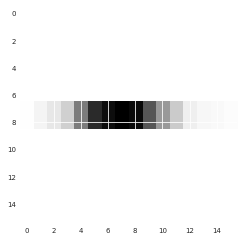

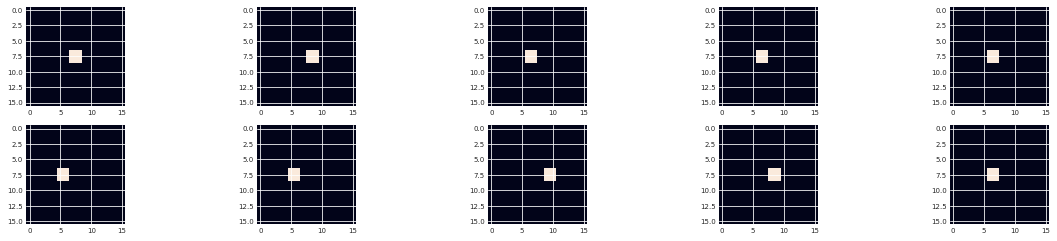

In [4]:
plt.imshow(np.mean(images, axis=0), interpolation='nearest', cmap=cm.Greys)
fig, axes = plt.subplots(2,5, figsize=(20,4))

for i_im, ax in enumerate(axes.flatten()):
    ax.imshow(images[i_im])

In [5]:
cuda = True

In [6]:
x = images[:,None,:,:]
y = np.zeros(len(x), dtype=np.float32)


In [7]:
from reversible.revnet import ReversibleBlock
import torch.nn as nn
def rev_block(n_chans, n_intermediate_chans):
    c = n_chans // 2
    n_i_c = n_intermediate_chans
    return ReversibleBlock(
        nn.Sequential(
            nn.Conv2d(c, n_i_c, (3,3), padding=1),
             nn.ReLU(),
             nn.Conv2d(n_i_c, c, (3,3), padding=1)),
        nn.Sequential(
            nn.Conv2d(c, n_i_c, (3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(n_i_c, c, (3,3), padding=1)))

def plot_sorted_examples(sorted_examples, cmap=cm.Greys_r, vmin=0,vmax=1):
    fig, axes = plt.subplots(2,10, figsize=(20,5))
    for ax, im in zip(axes.flatten(), sorted_examples.squeeze()):
        ax.imshow(im, vmin=vmin, vmax=vmax,cmap=cmap)
    return fig


In [8]:
from reversible.iterator import GenerativeIterator
from reversible.revnet import SubsampleSplitter, ViewAs
from reversible.util import set_random_seeds
from reversible.revnet import init_model_params
import torch as th
set_random_seeds(34093049, True)
feature_model = th.nn.Sequential(
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(4,25),
    rev_block(4,25),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(16,50),
    rev_block(16,50),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(64,100),
    rev_block(64,100),
    ViewAs((-1,64,2,2),(-1,64*2*2)),)
if cuda:
    feature_model = feature_model.cuda()
init_model_params(feature_model, 1)

n_dims = int(np.prod(x.shape[1:]))
n_clusters = int(len(np.unique(y)))
means_per_dim = th.autograd.Variable(th.zeros(n_clusters,n_dims) * 1.0, requires_grad=True)
stds_per_dim = th.autograd.Variable(th.ones(n_clusters,n_dims)  * 0.5, requires_grad=True)

In [9]:
from reversible.sliced import sample_directions
from reversible.util import np_to_var
directions_adv = th.cat([sample_directions(n_dims, True,False),
                         sample_directions(n_dims, True,False),
                         sample_directions(n_dims, True,False),
                        ],dim=0)
directions_adv = th.autograd.Variable(directions_adv.data, requires_grad=True)

inputs = np_to_var(x, dtype=np.float32)
targets = np_to_var((y+1)[:,None], dtype=np.float32)
if cuda == True:
    means_per_dim = th.autograd.Variable(means_per_dim.cuda().data, requires_grad=True)
    stds_per_dim = th.autograd.Variable(stds_per_dim.cuda().data, requires_grad=True)
    directions_adv = directions_adv.cuda()
    inputs = inputs.cuda()
    targets = targets.cuda()

from reversible.training import init_std_mean

init_std_mean(feature_model, inputs, targets, means_per_dim, stds_per_dim,
                 set_phase_interval=True)

optimizer = th.optim.Adam([
    {'params': list(feature_model.parameters()),# + 
                       #[means_per_dim, stds_per_dim],
    'lr': 0.001},],
{'params':[directions_adv,],
    'lr': -0.001},)
iterator = GenerativeIterator(upsample_supervised=True, batch_size=len(inputs))


In [13]:

from reversible.revnet import invert
from reversible.gaussian import get_gauss_samples
def reconstruct_loss(o,m,s):
    o = o.detach()
    inputs = invert(feature_model, o)
    o_perturbed = o + get_gauss_samples(len(o), m*0, s * 0 + 0.01)
    inputs_perturbed = invert(feature_model, o_perturbed)
    diffs = inputs - inputs_perturbed
    loss = th.mean(diffs * diffs)
    loss += th.mean(th.abs(diffs))
    return loss
    

In [14]:
from reversible.sinkhorn import sinkhorn_to_gauss_dist
from reversible.sliced import sliced_from_samples_for_gauss_dist
from reversible.loss_util import hard_loss_per_cluster

hard_loss_fn = lambda o,m,s : (sinkhorn_to_gauss_dist(o,m,s, epsilon=1e-1, stop_threshold=0.001)
                              + 15 * sliced_from_samples_for_gauss_dist(o,m,s,n_dirs=4, adv_dirs=None)
                              + 15 * reconstruct_loss(o,m,s))
#hard_loss_fn = lambda o,m,s : sliced_from_samples_for_gauss_dist(o,m,s,n_dirs=2, adv_dirs=directions_adv)
loss_fn = lambda o,d,t,m,s: hard_loss_per_cluster(o,t,m,s, hard_loss_fn)

loss_fn_adv = None # no adversarial training

## let's disable all dimensions except 1

In [15]:
means_per_dim.data = means_per_dim.data * 0
stds_per_dim.data = stds_per_dim.data * 0
stds_per_dim.data[0,131] = 1

In [16]:
def train_one_batch(iterator, feature_model, loss_fn, means_per_dim, stds_per_dim,
                   optimizer):
    b = iterator.get_batches(inputs, targets, None, None)
    b_X, b_y = b.__next__()
    outs = feature_model(b_X)
    loss = loss_fn(outs, None, b_y, means_per_dim, stds_per_dim)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = var_to_np(loss)[0]
    return loss

In [17]:
n_batches_per_dataset = len([b for b in iterator.get_batches(inputs, targets, None, None)])
n_critic_updates = 0
n_updates_per_epoch = int(np.ceil(n_batches_per_dataset / (n_critic_updates + 1.0)))

,total_loss
0,5.49095


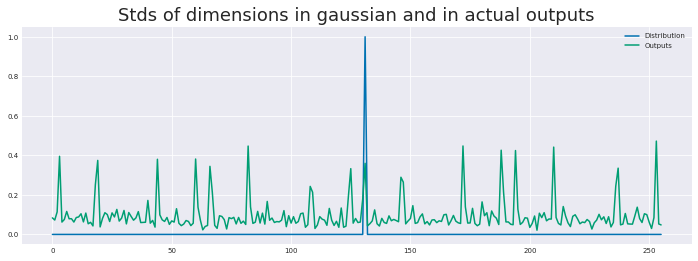

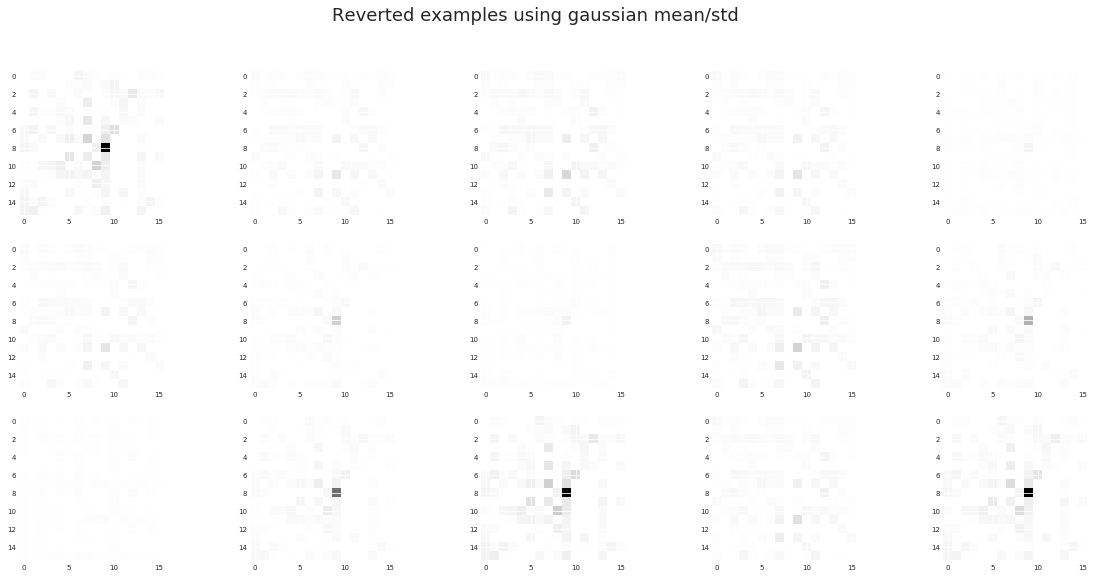

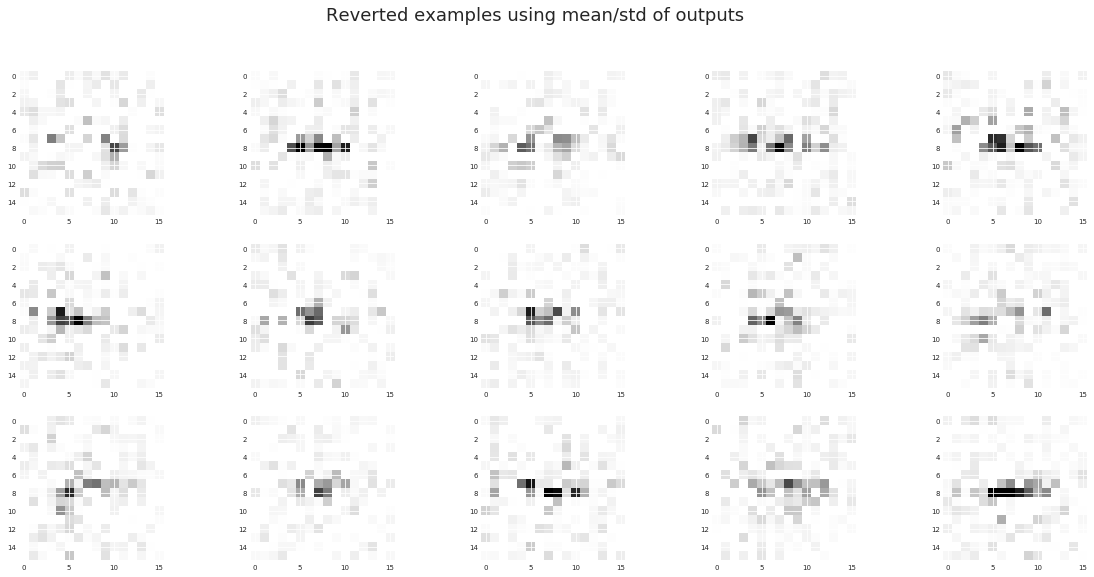

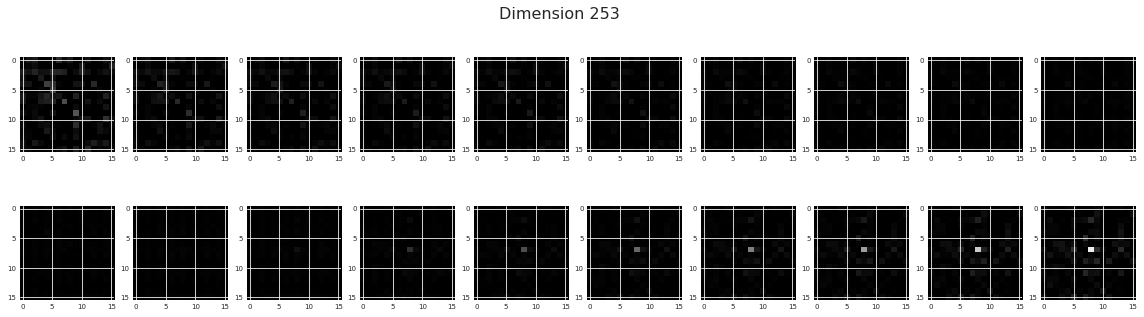

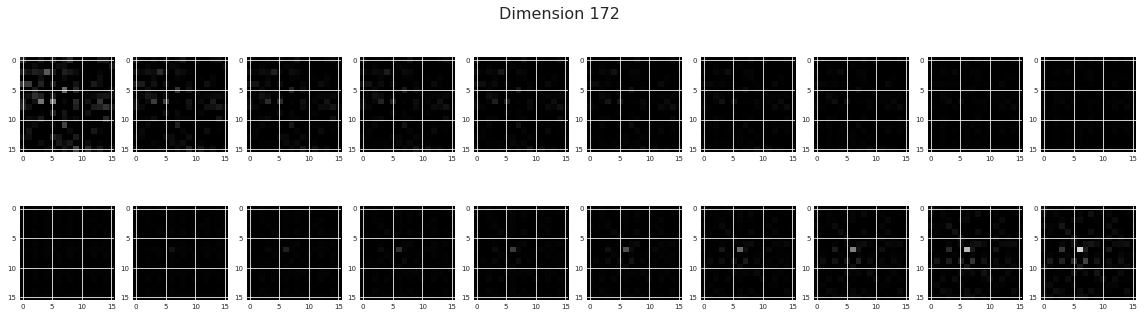

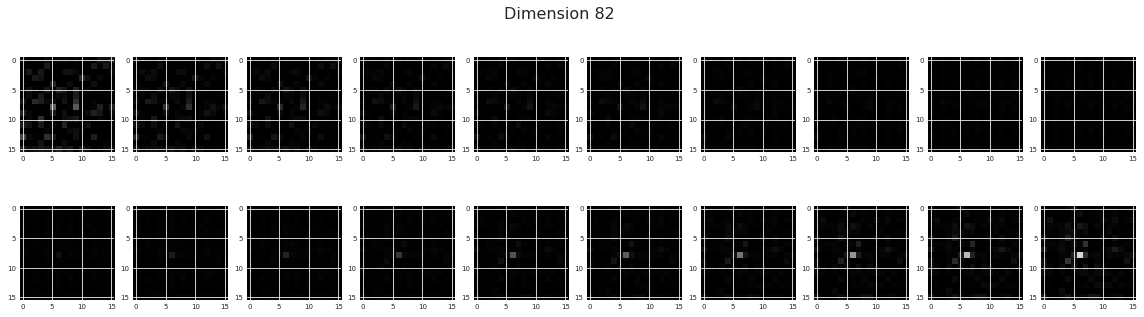

,total_loss
10,1.97147


,total_loss
20,1.569899


,total_loss
30,1.139627


,total_loss
40,0.915318


,total_loss
50,0.837366


,total_loss
60,0.806524


,total_loss
70,0.820958


,total_loss
80,0.797892


,total_loss
90,0.826822


,total_loss
100,0.73316


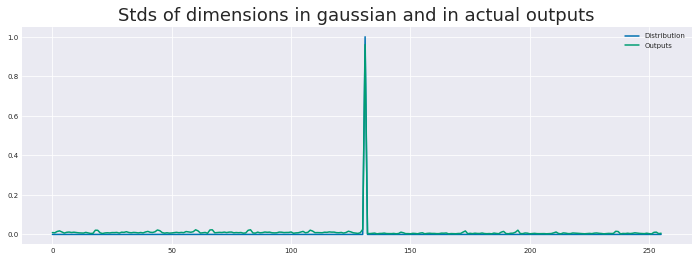

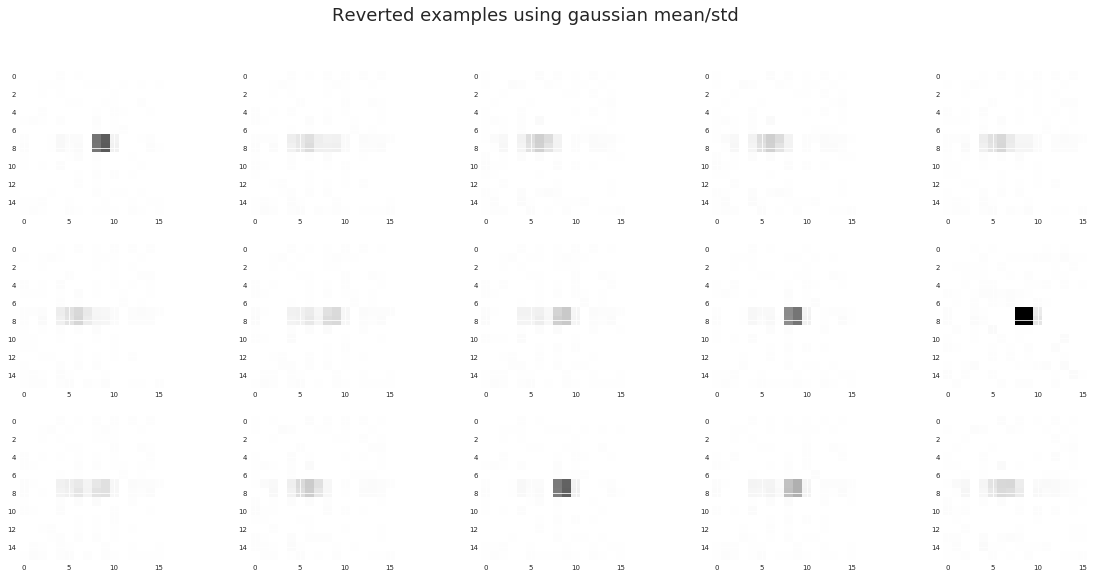

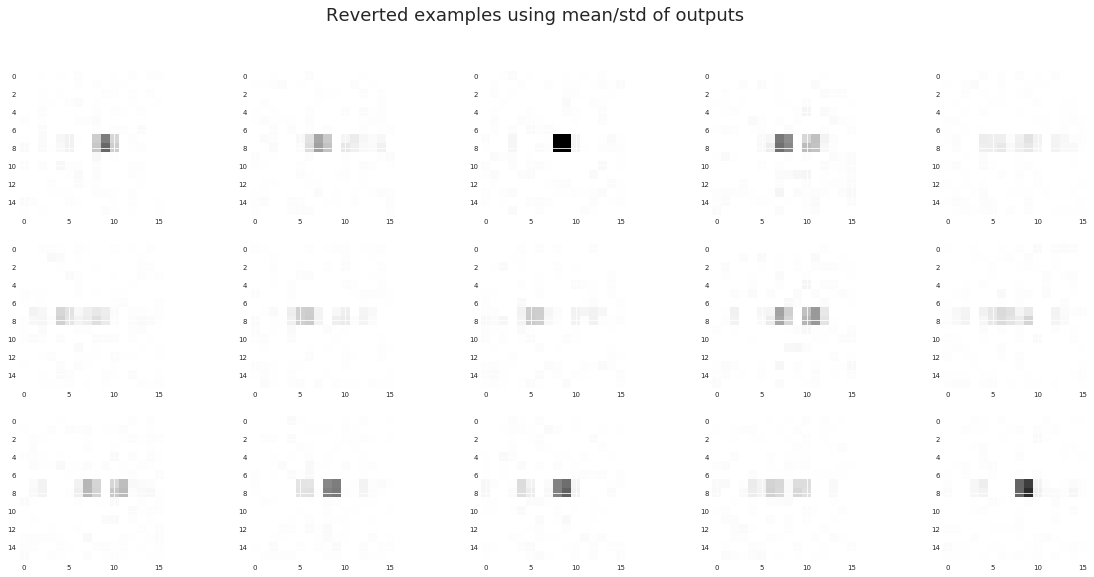

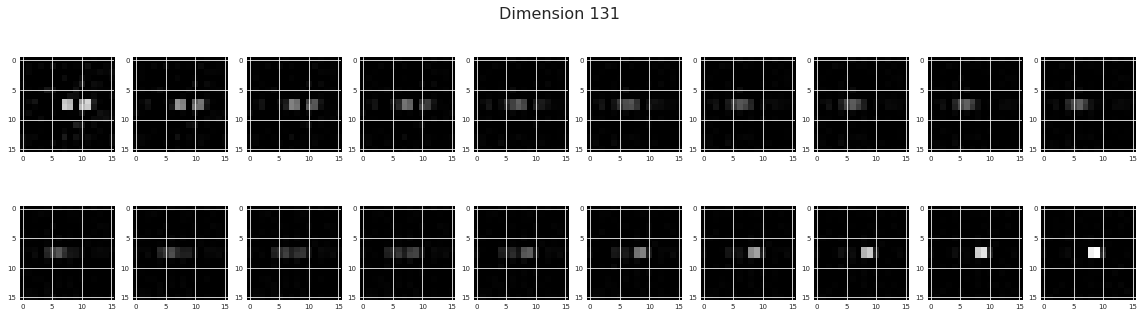

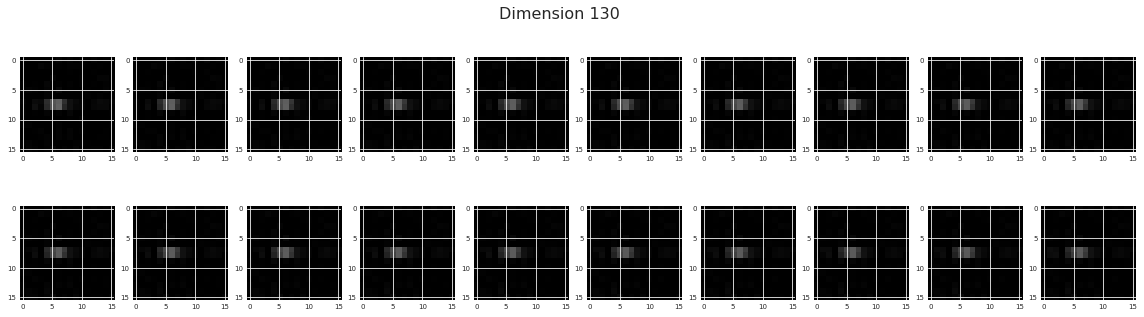

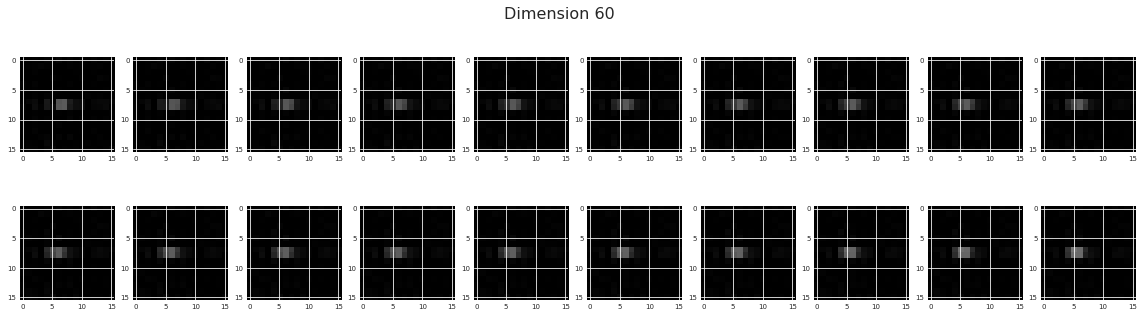

,total_loss
110,0.741385


,total_loss
120,0.774336


,total_loss
130,0.739905


,total_loss
140,0.770223


,total_loss
150,0.820274


,total_loss
160,0.694961


,total_loss
170,0.716434


,total_loss
180,0.696462


,total_loss
190,0.716717


,total_loss
200,0.700013


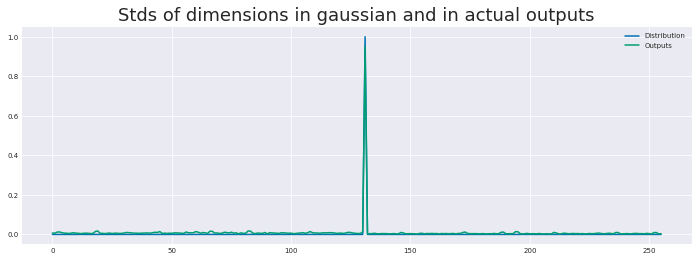

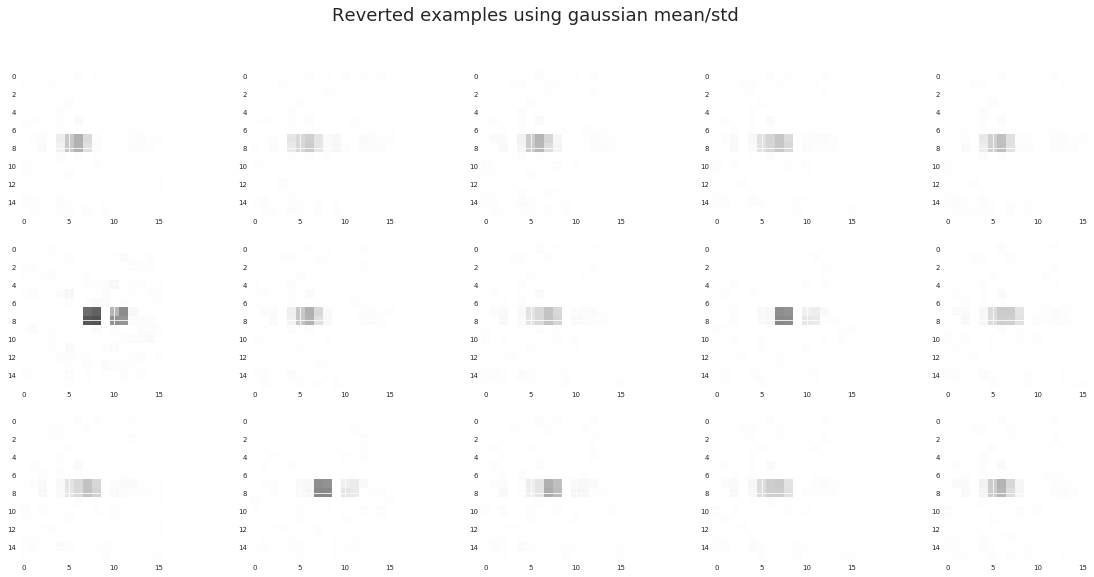

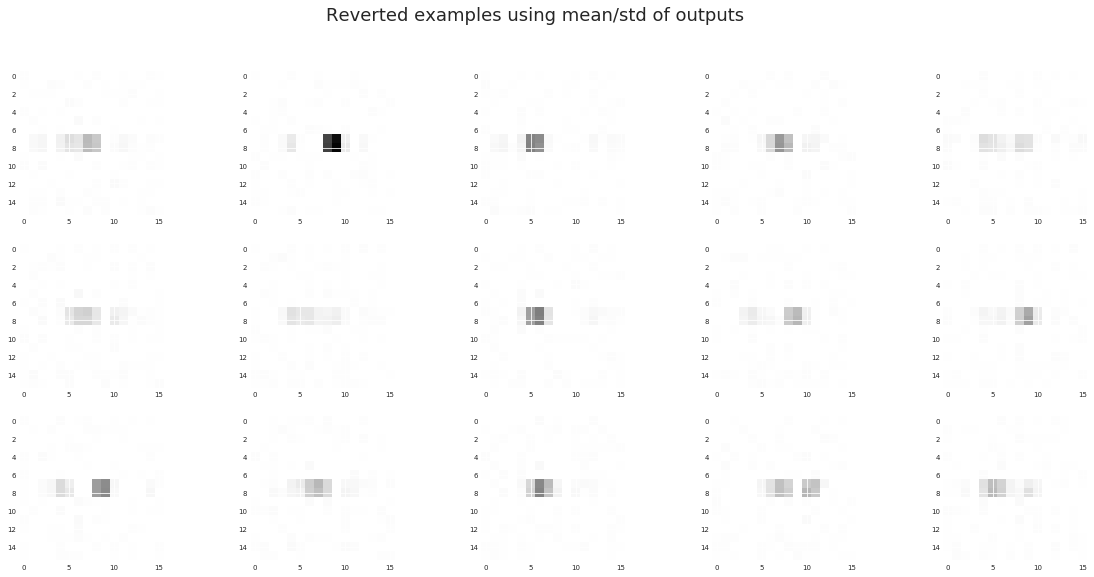

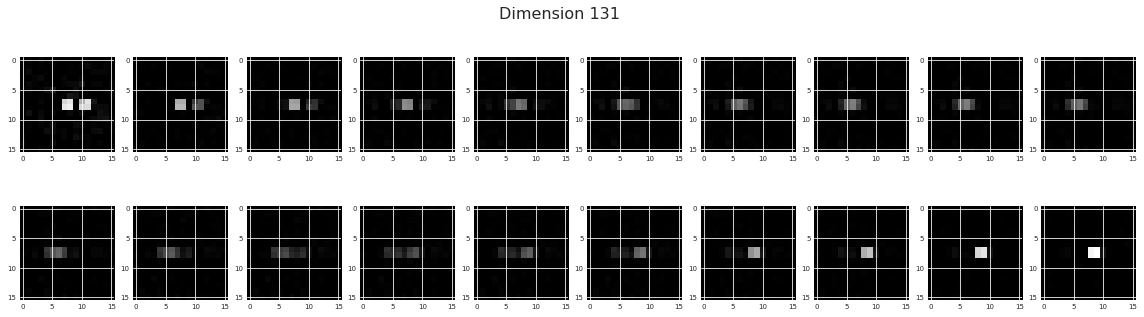

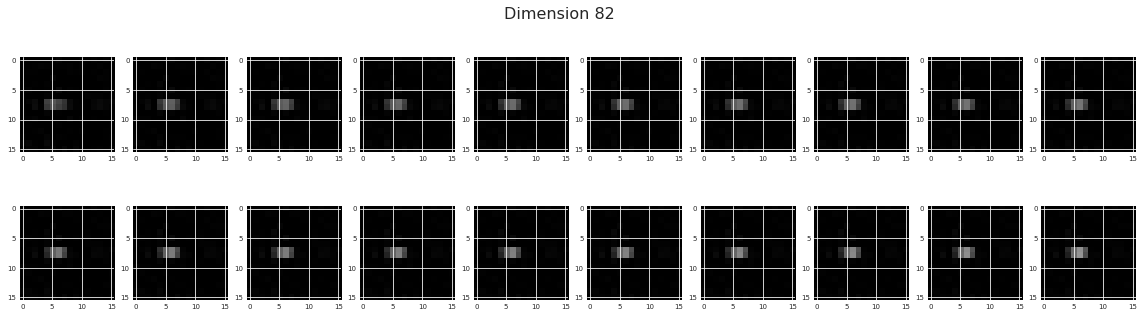

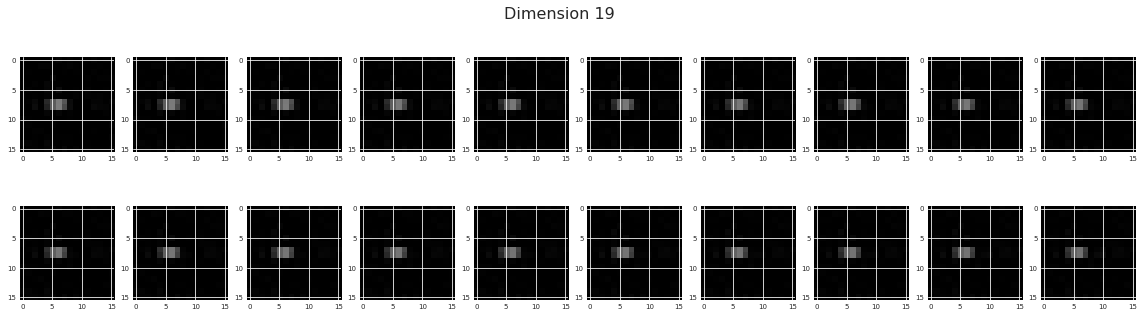

,total_loss
210,0.726474


,total_loss
220,0.721355


,total_loss
230,0.692413


,total_loss
240,0.715417


,total_loss
250,0.702668


,total_loss
260,0.674599


,total_loss
270,0.758051


,total_loss
280,0.709697


,total_loss
290,0.679183


,total_loss
300,0.698431


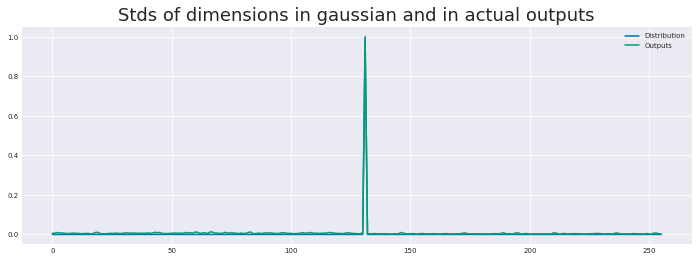

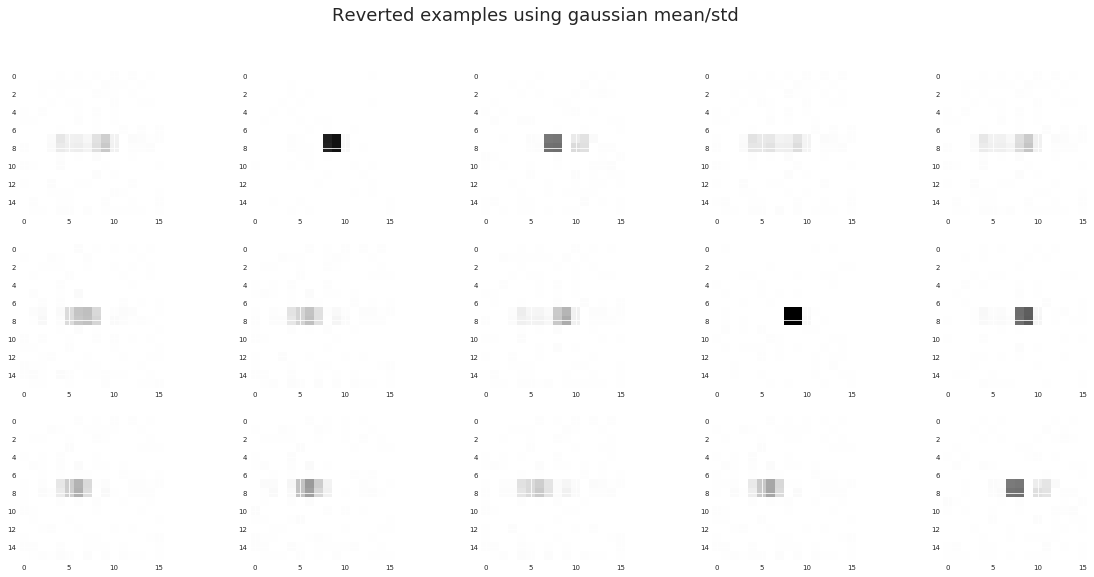

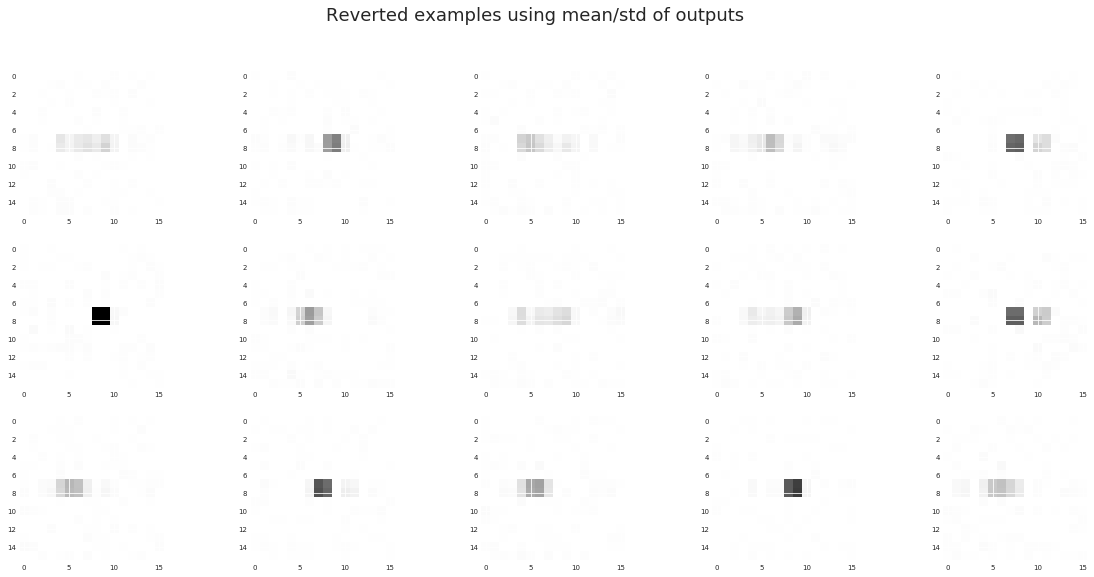

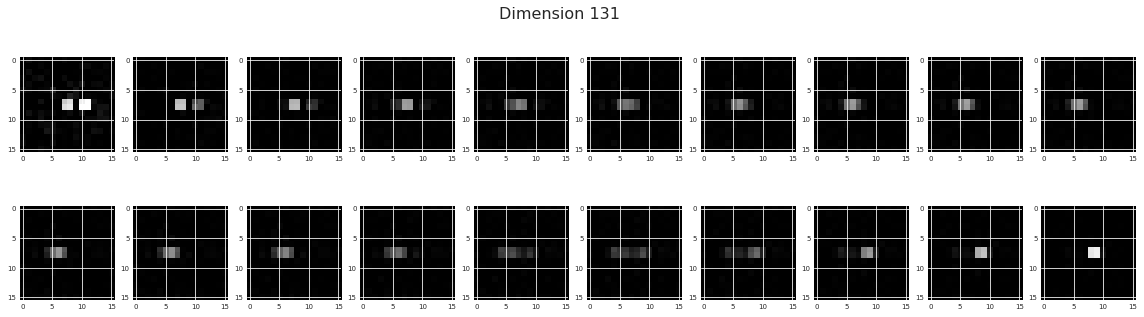

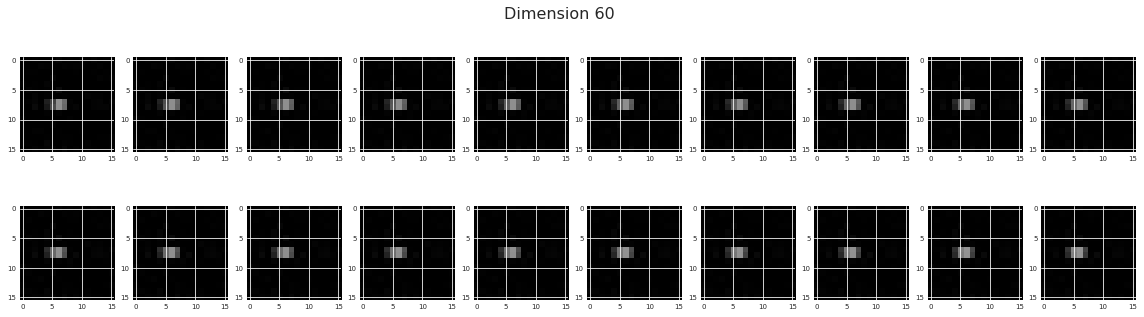

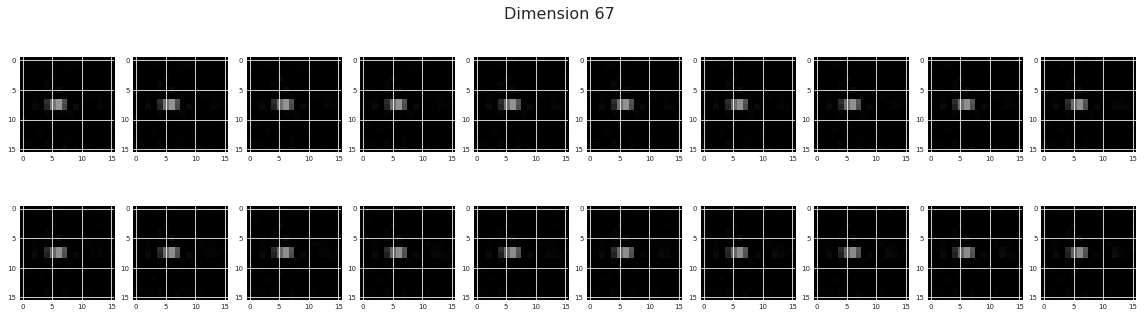

,total_loss
310,0.714686


,total_loss
320,0.710345


,total_loss
330,0.700285


,total_loss
340,0.717945


,total_loss
350,0.664417


,total_loss
360,0.681167


,total_loss
370,0.676438


,total_loss
380,0.671461


,total_loss
390,0.654394


,total_loss
400,0.712909


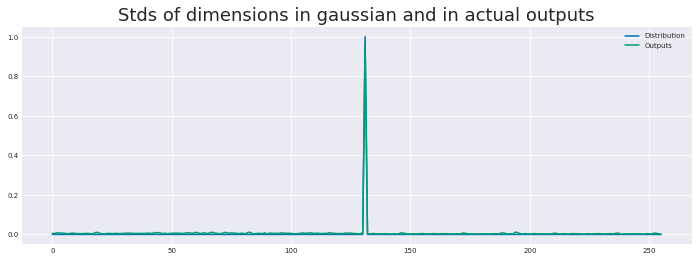

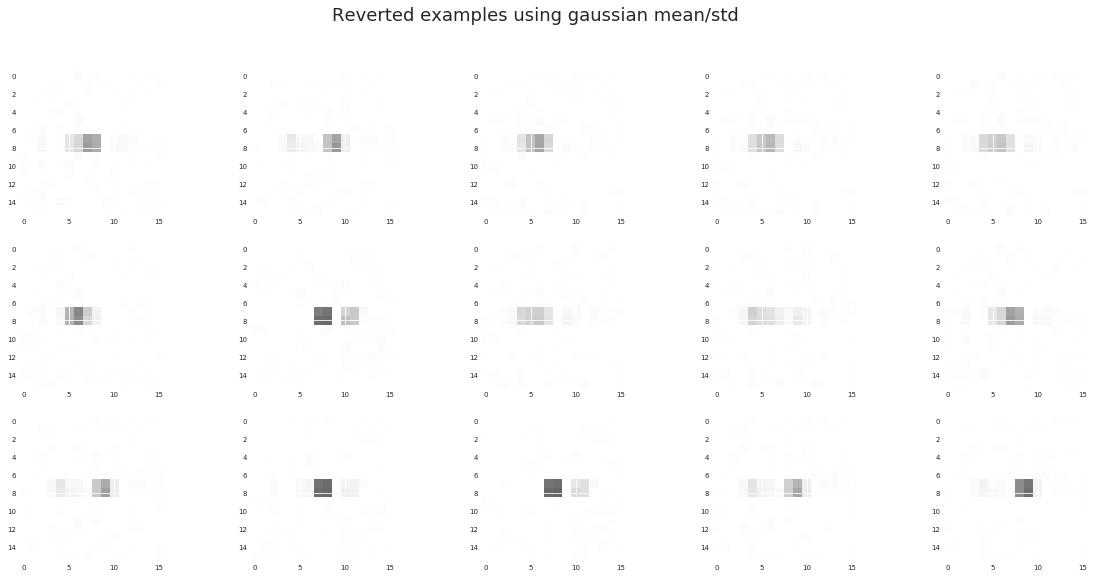

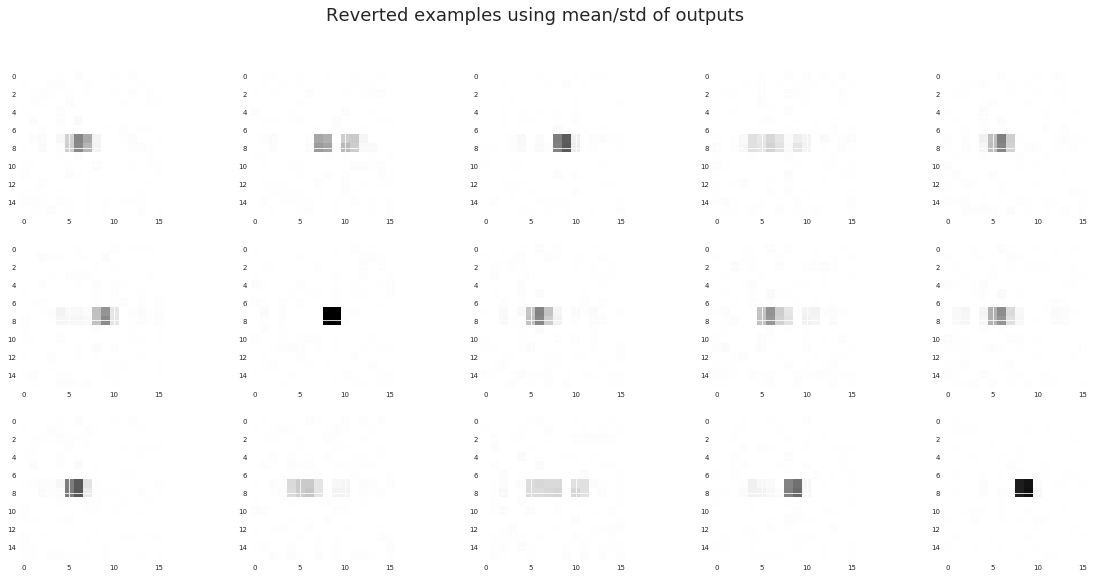

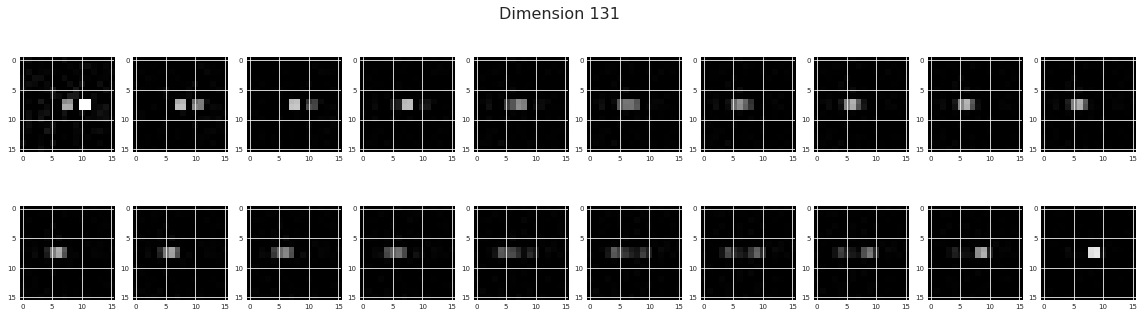

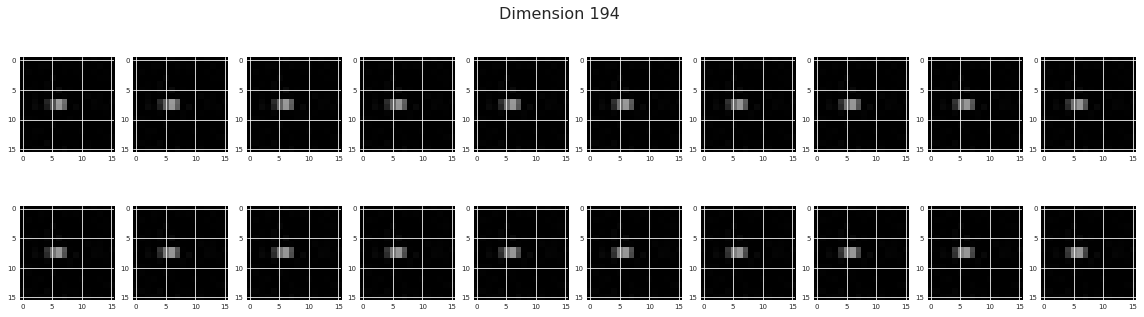

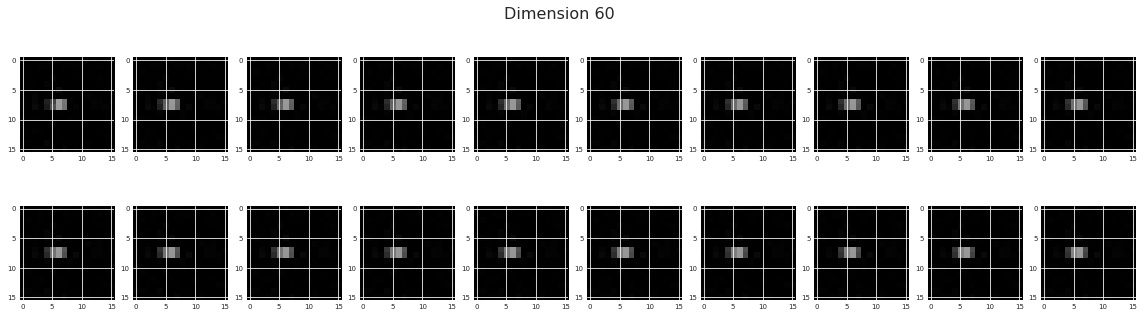

,total_loss
410,0.667124


,total_loss
420,0.694583


,total_loss
430,0.683605


,total_loss
440,0.690002


,total_loss
450,0.670494


,total_loss
460,0.679055


,total_loss
470,0.696331


,total_loss
480,0.66975


,total_loss
490,0.672478


,total_loss
500,0.658593


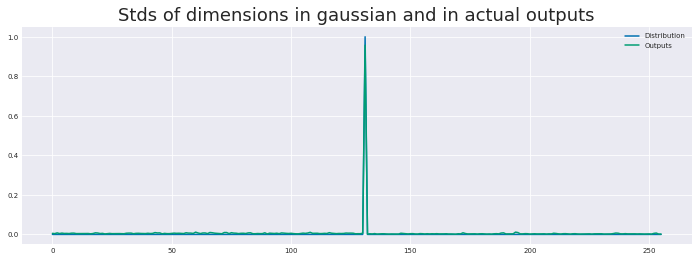

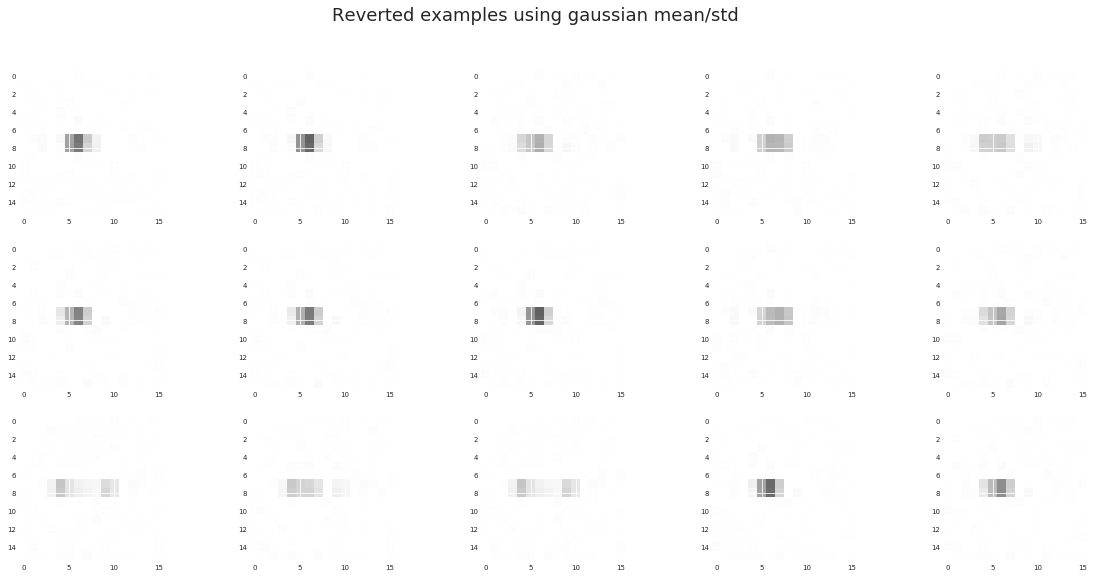

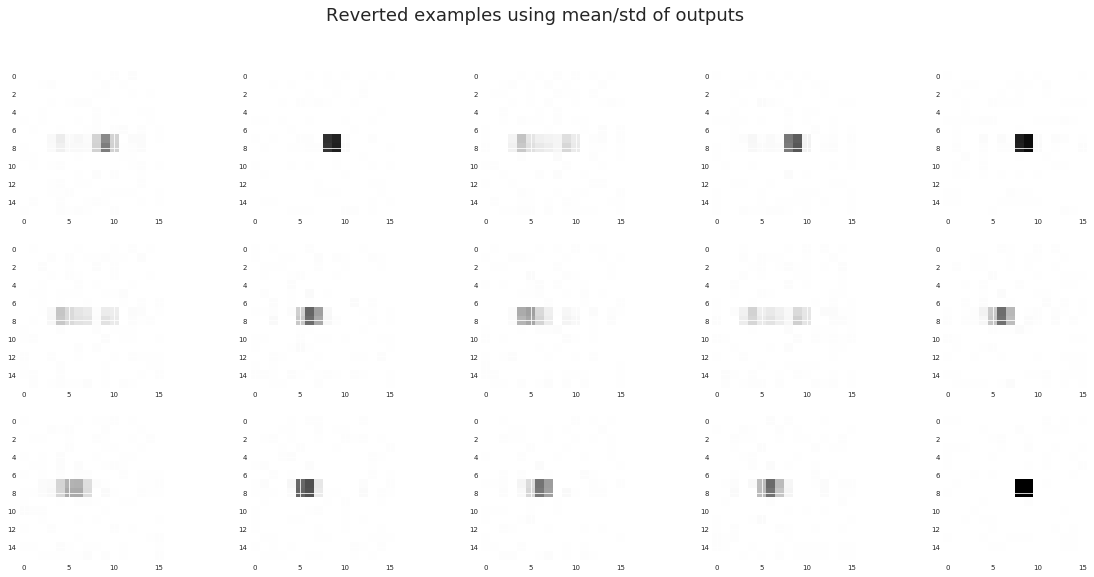

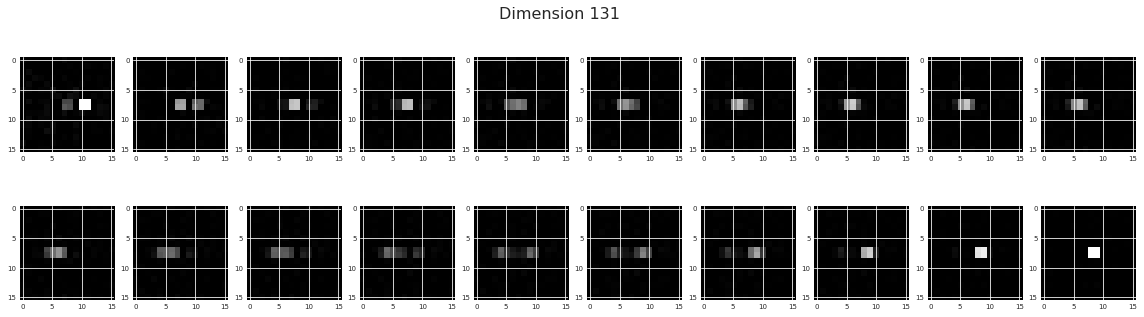

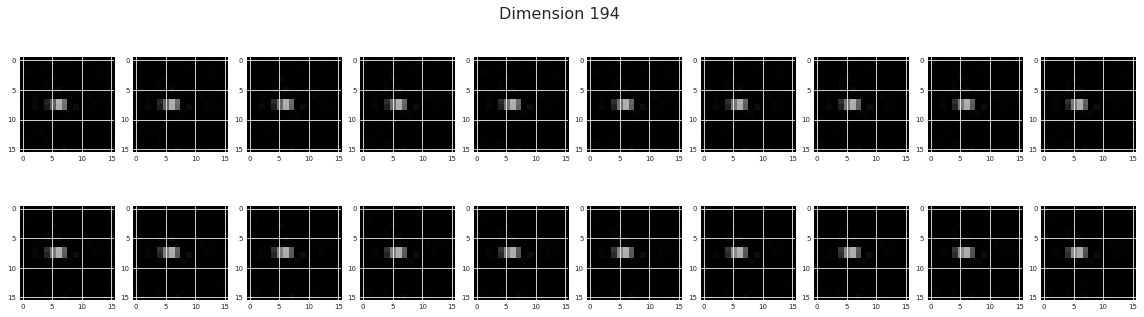

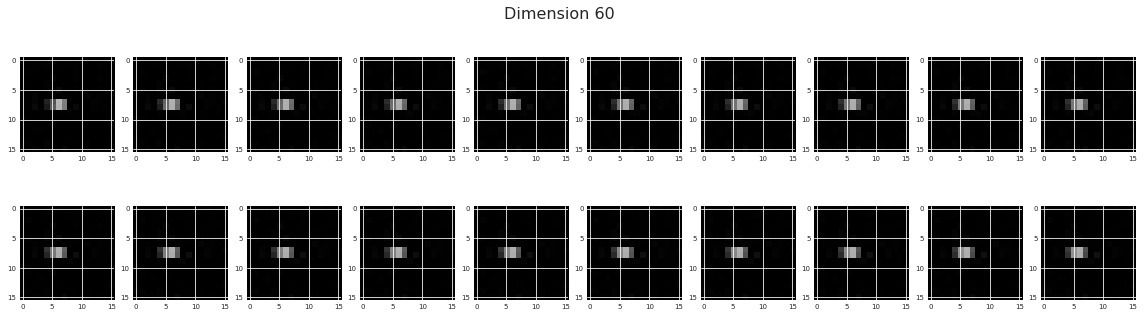

,total_loss
510,0.650821


,total_loss
520,0.646923


,total_loss
530,0.678234


,total_loss
540,0.703615


,total_loss
550,0.653294


,total_loss
560,0.661533


,total_loss
570,0.657558


,total_loss
580,0.645353


,total_loss
590,0.717296


,total_loss
600,0.65212


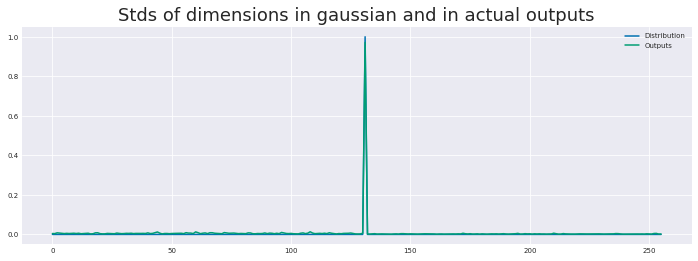

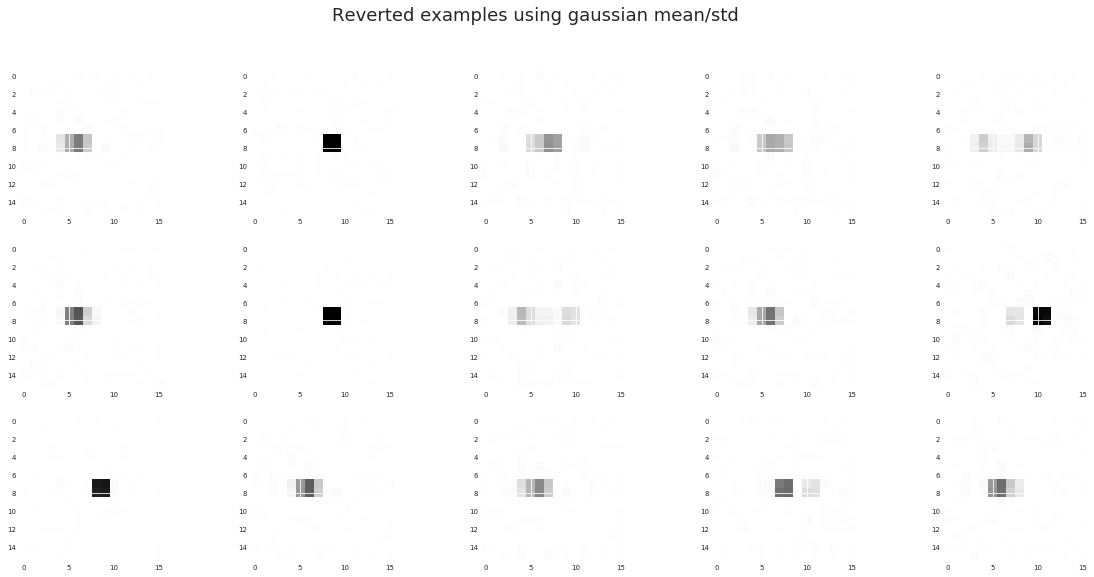

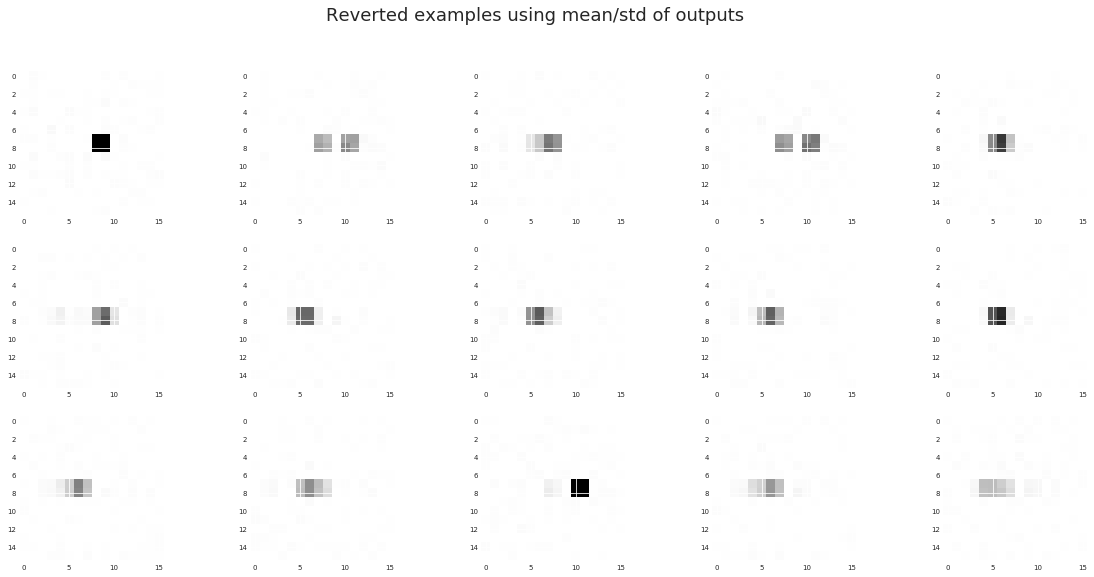

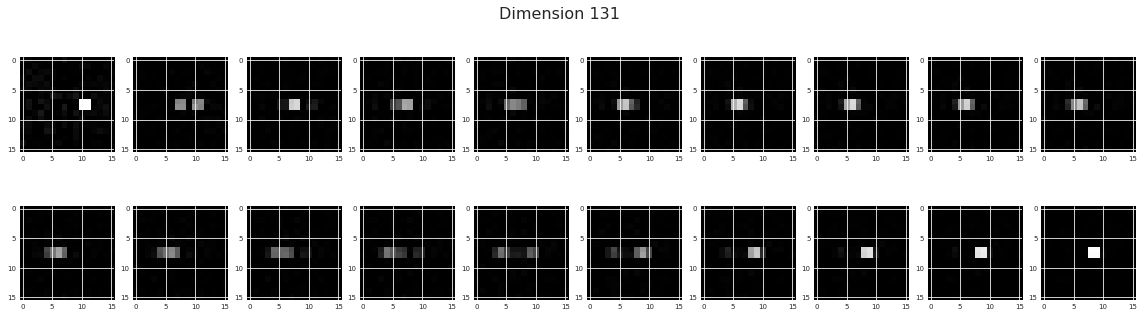

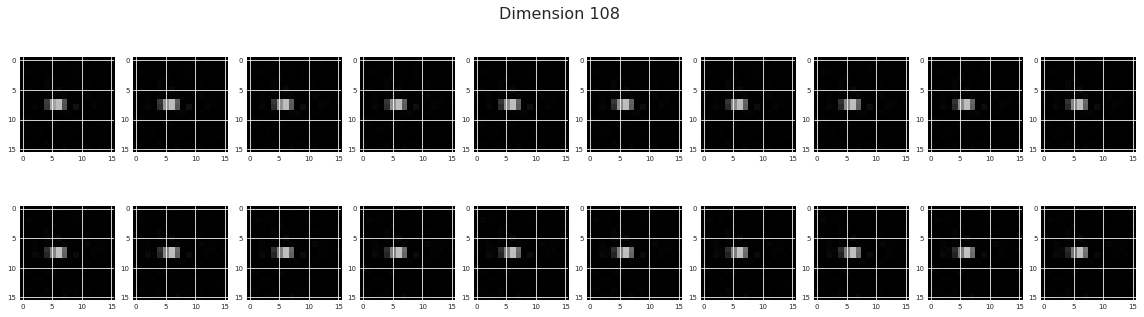

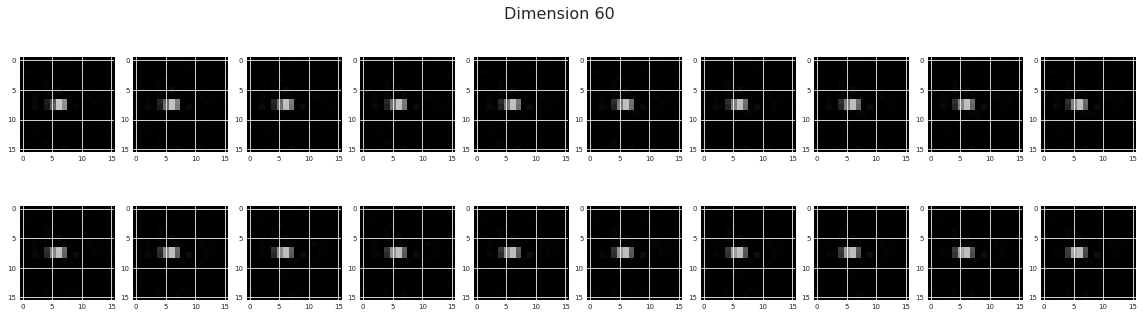

,total_loss
610,0.68522


,total_loss
620,0.720878


,total_loss
630,0.65612


,total_loss
640,0.704314


,total_loss
650,0.653897


,total_loss
660,0.672842


,total_loss
670,0.643997


,total_loss
680,0.642101


,total_loss
690,0.72553


,total_loss
700,0.665657


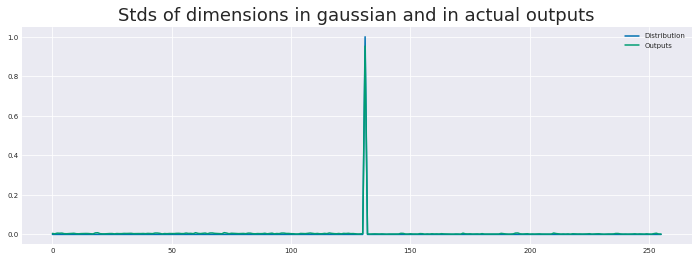

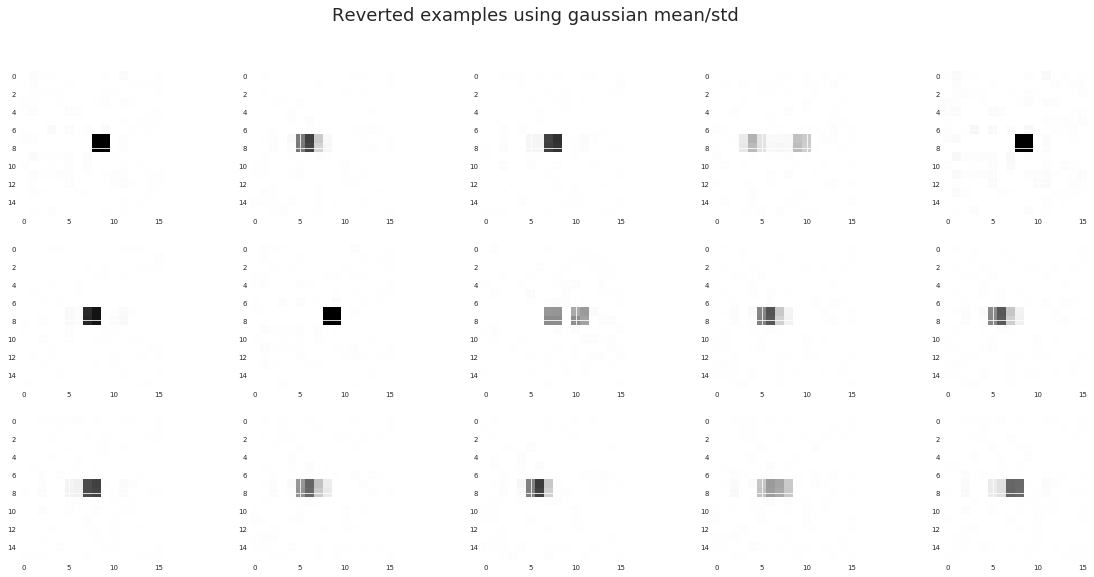

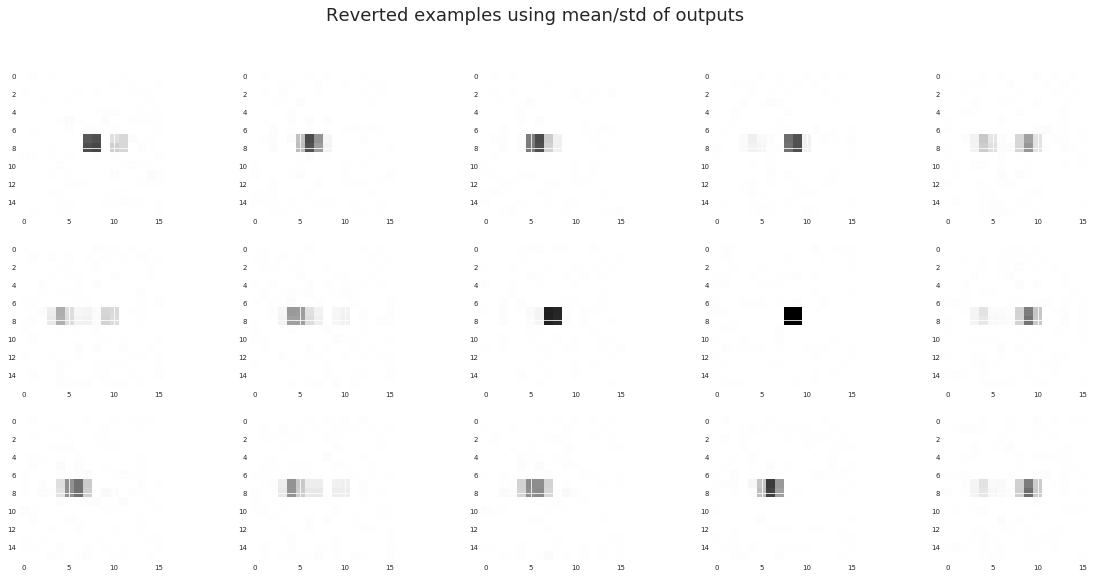

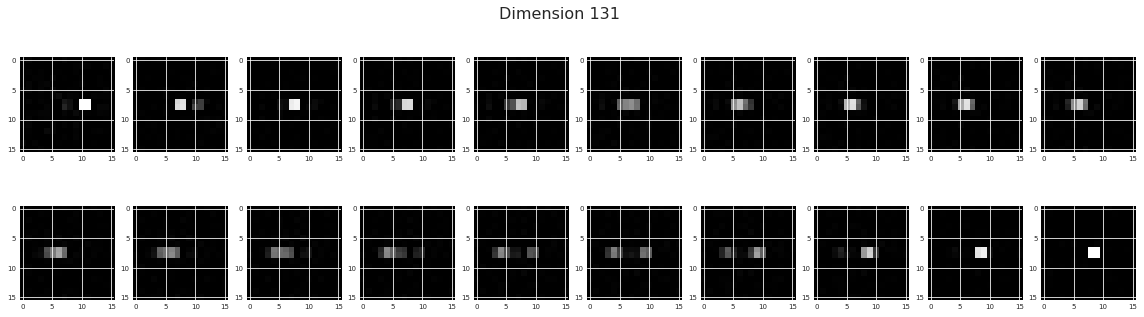

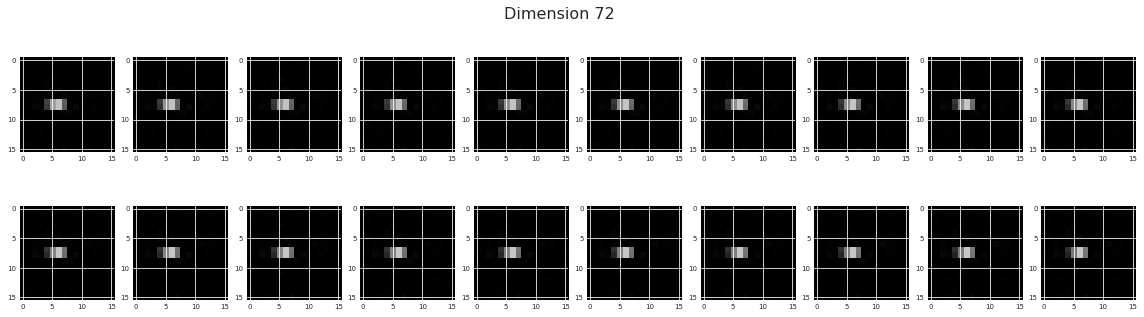

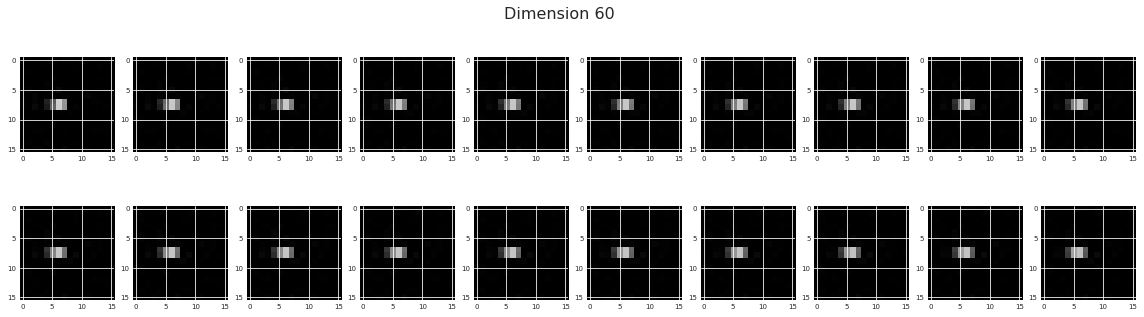

,total_loss
710,0.642261


,total_loss
720,0.656847


,total_loss
730,0.666887


,total_loss
740,0.694738


,total_loss
750,0.661333


,total_loss
760,0.689297


,total_loss
770,0.634681


,total_loss
780,0.650805


,total_loss
790,0.698229


,total_loss
800,0.689293


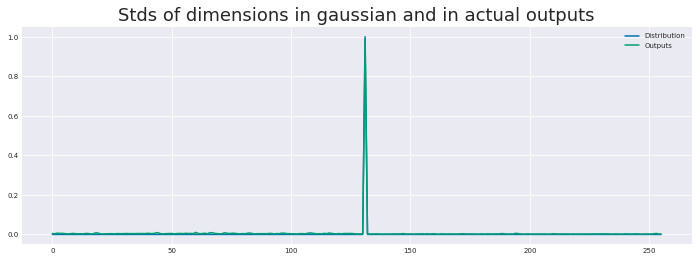

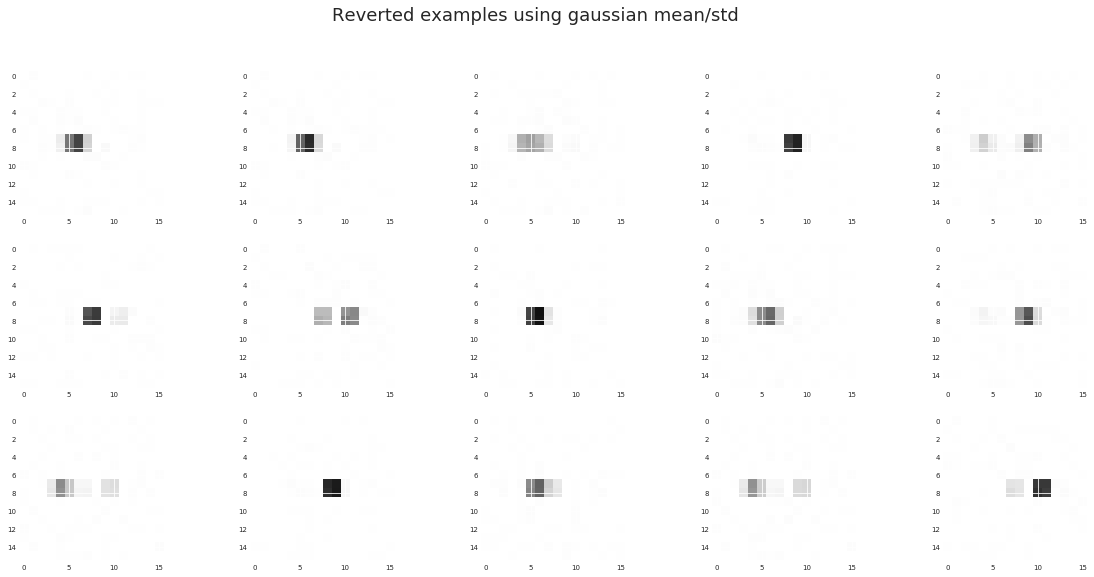

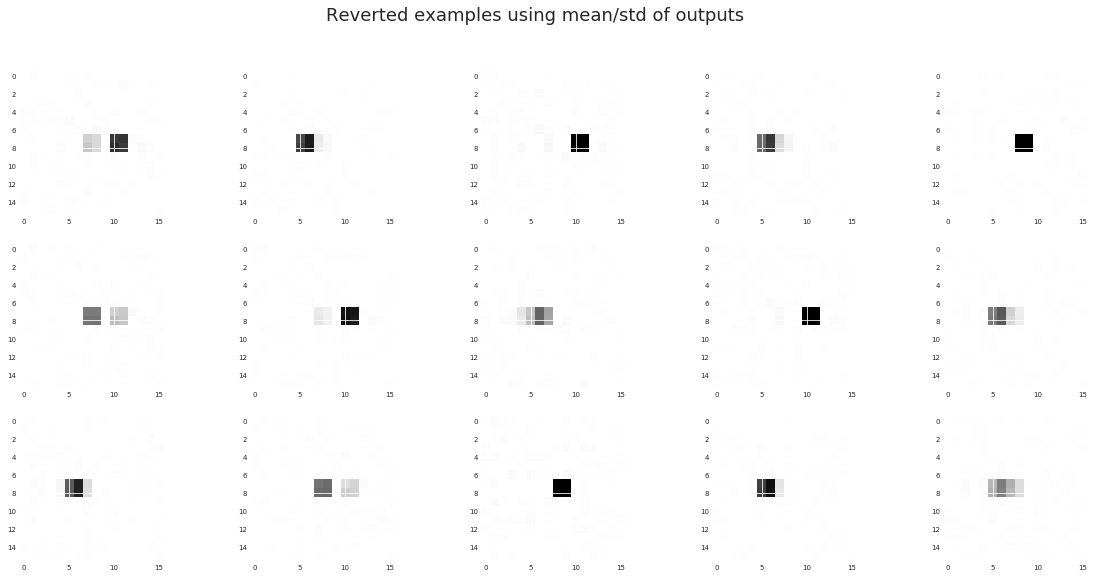

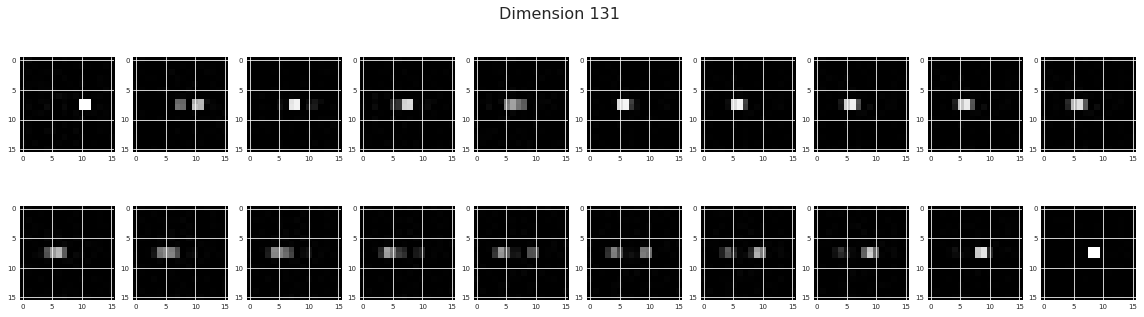

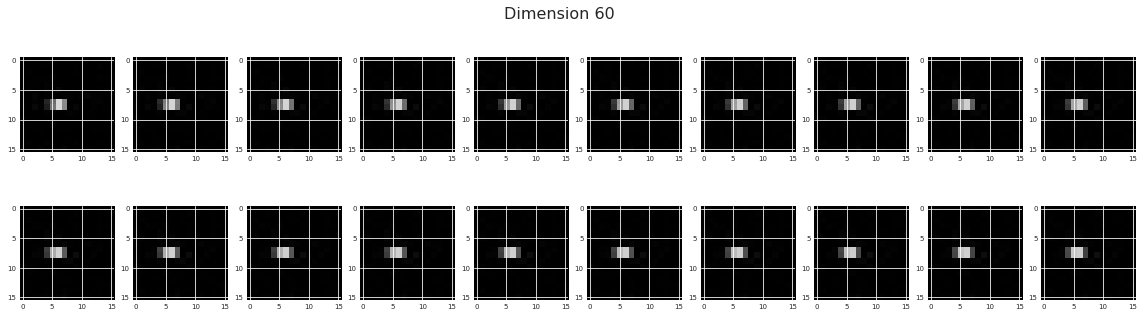

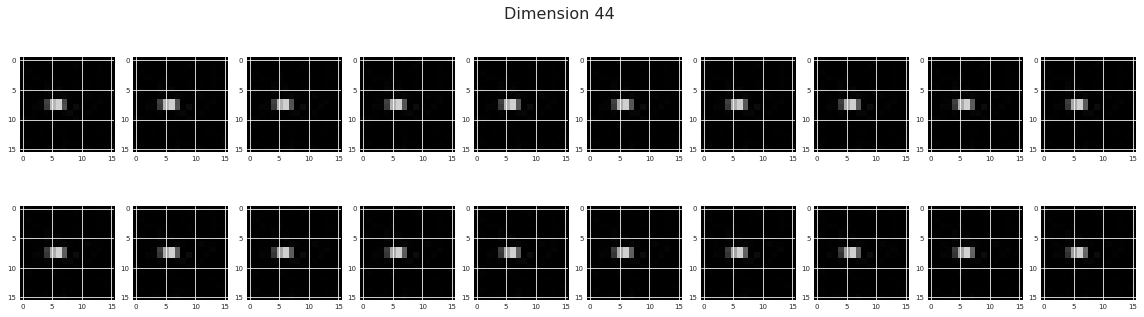

,total_loss
810,0.68506


,total_loss
820,0.677007


,total_loss
830,0.696253


,total_loss
840,0.680131


,total_loss
850,0.667858


,total_loss
860,0.669558


,total_loss
870,0.634612


,total_loss
880,0.641449


,total_loss
890,0.642477


,total_loss
900,0.638152


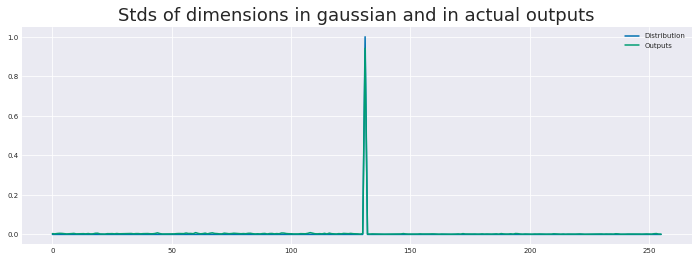

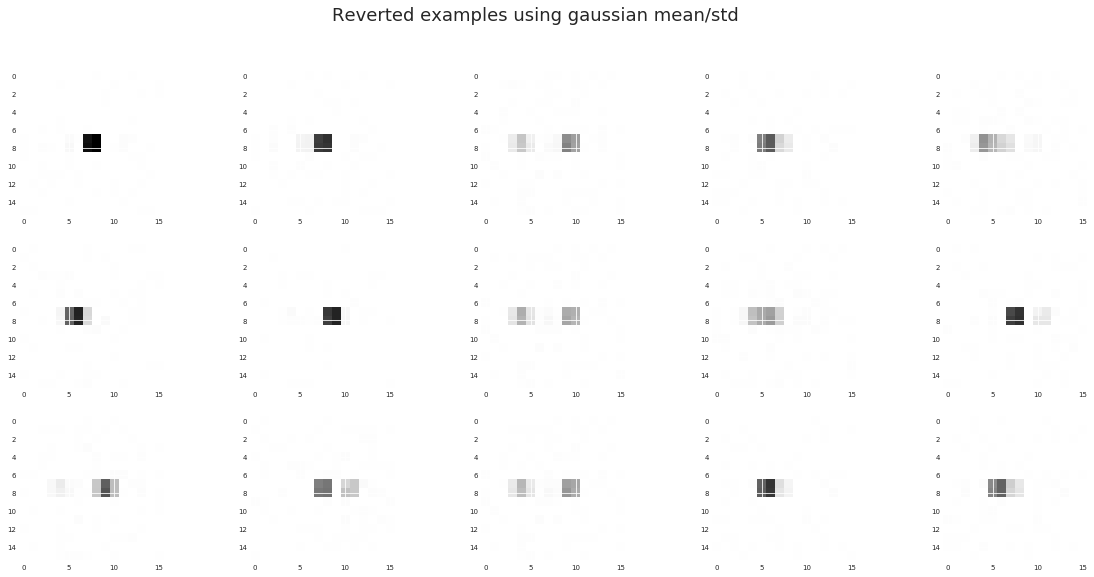

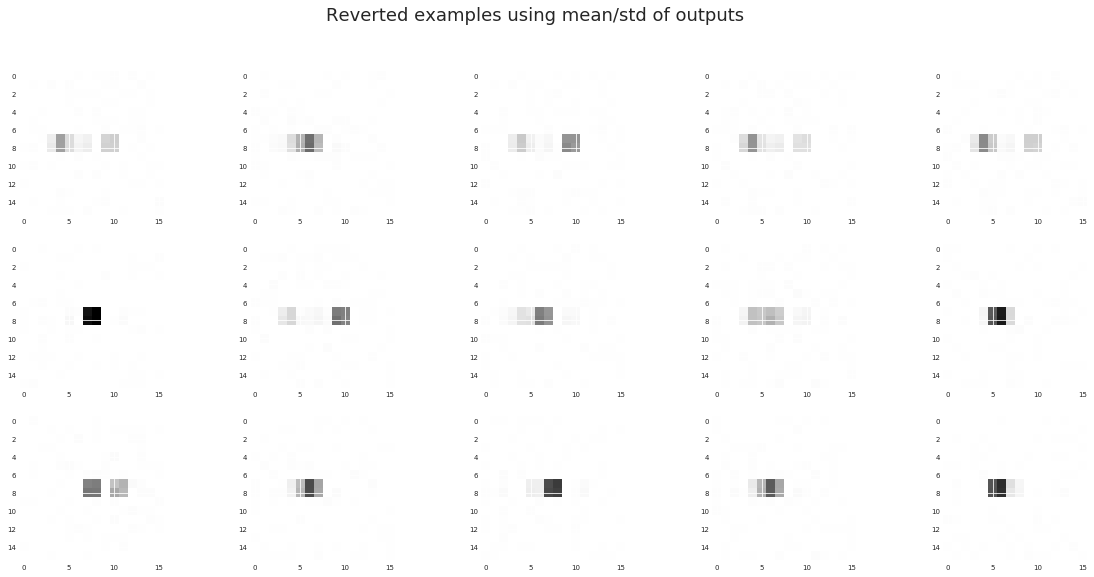

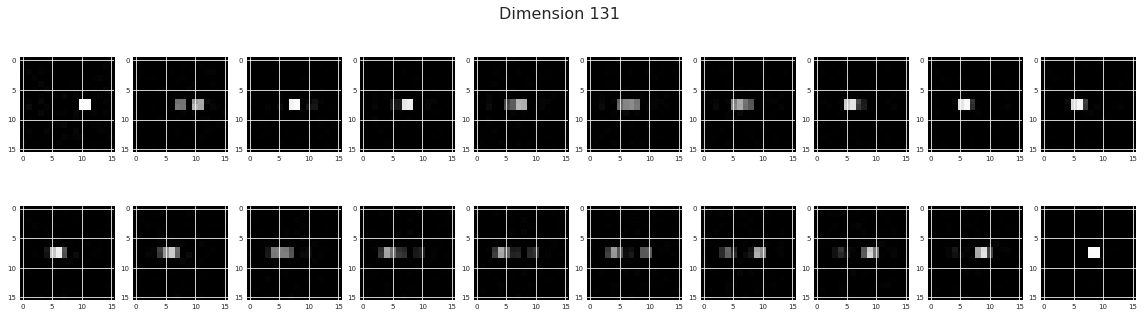

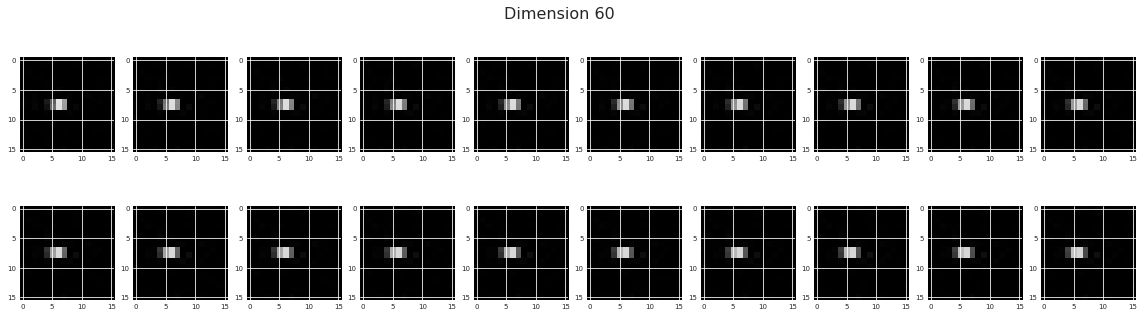

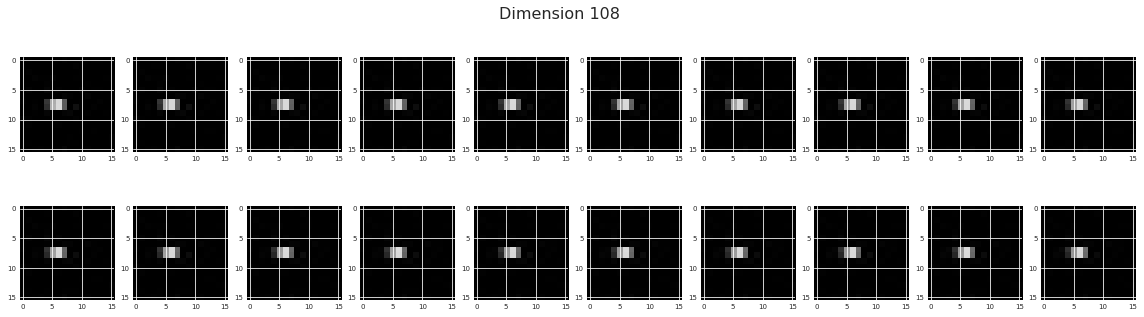

,total_loss
910,0.62944


,total_loss
920,0.679419


,total_loss
930,0.678234


,total_loss
940,0.643733


,total_loss
950,0.66731


,total_loss
960,0.650823


,total_loss
970,0.624767


,total_loss
980,0.638826


,total_loss
990,0.678758


,total_loss
1000,0.670037


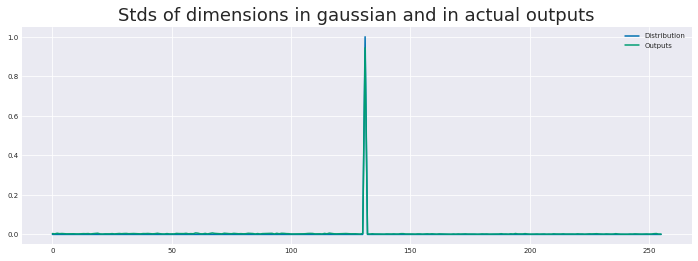

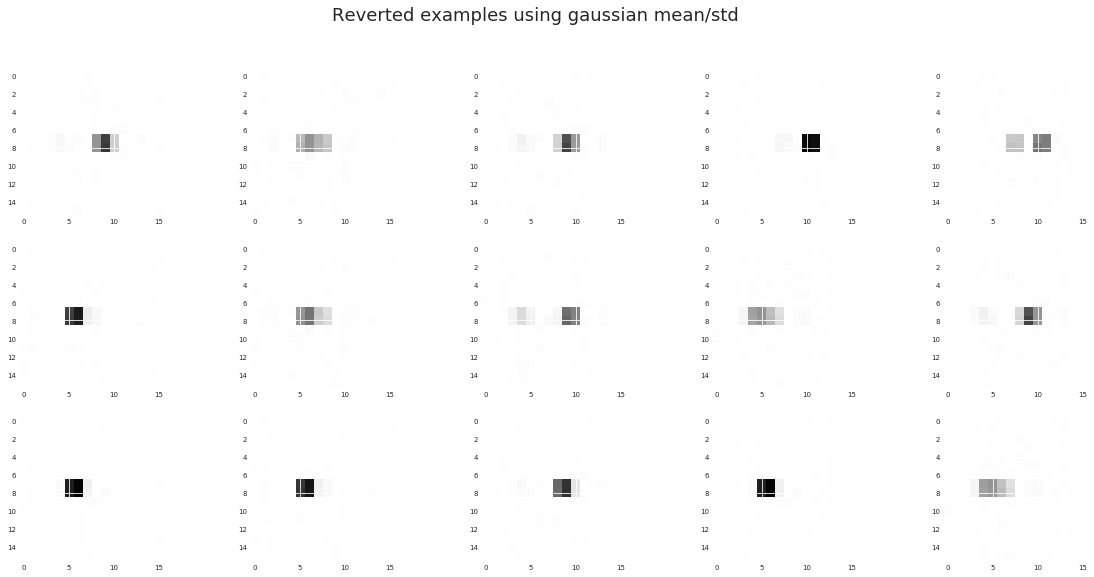

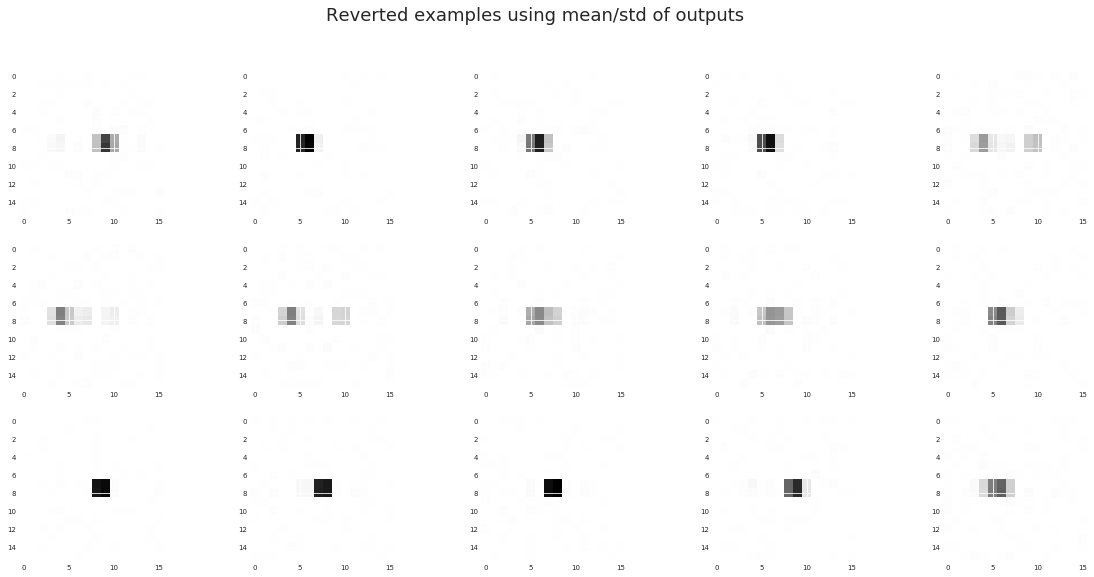

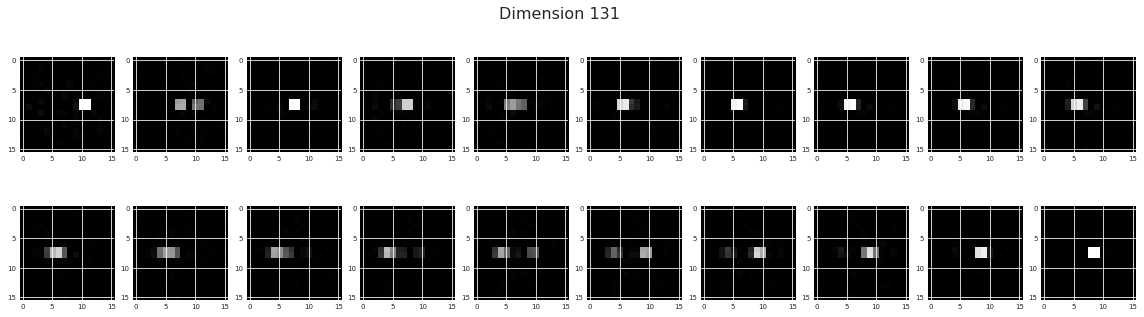

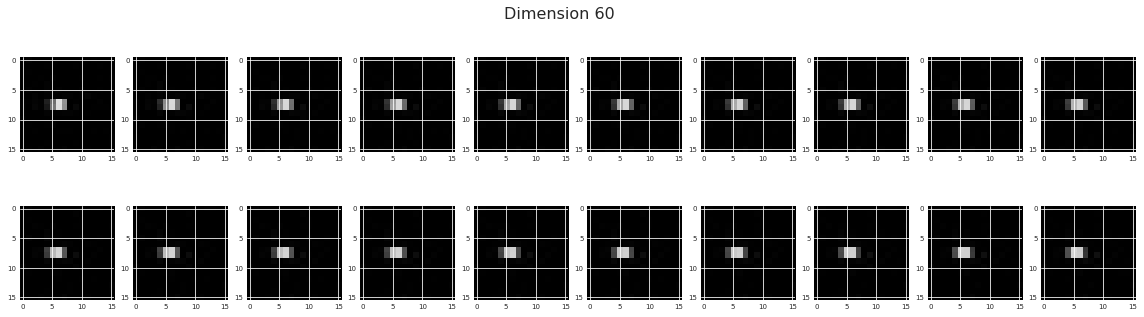

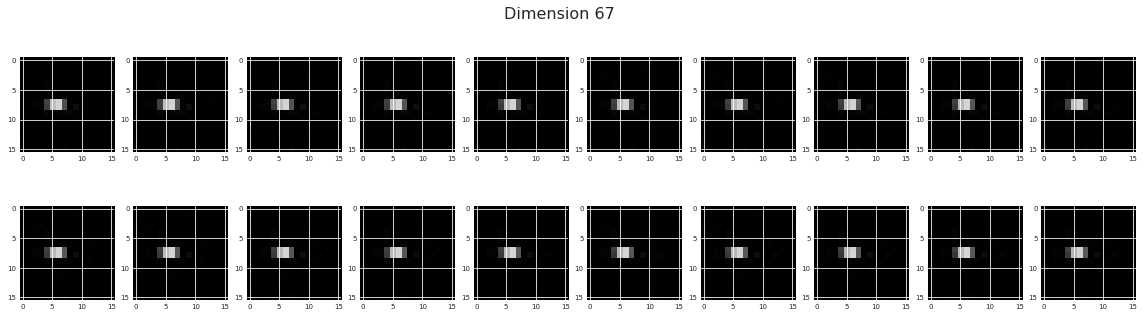

,total_loss
1010,0.648988


,total_loss
1020,0.642391


,total_loss
1030,0.668861


,total_loss
1040,0.699099


,total_loss
1050,0.643553


,total_loss
1060,0.652343


,total_loss
1070,0.641965


,total_loss
1080,0.632005


,total_loss
1090,0.645117


,total_loss
1100,0.655603


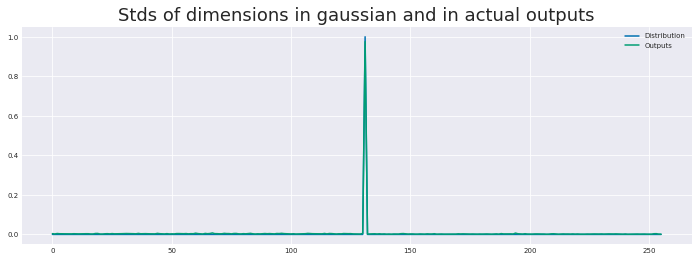

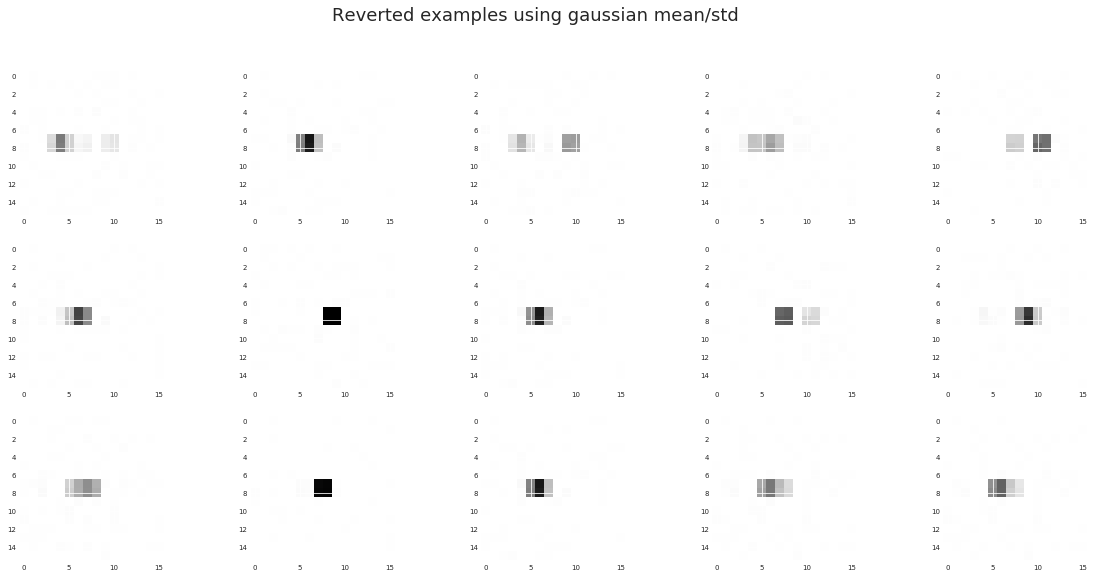

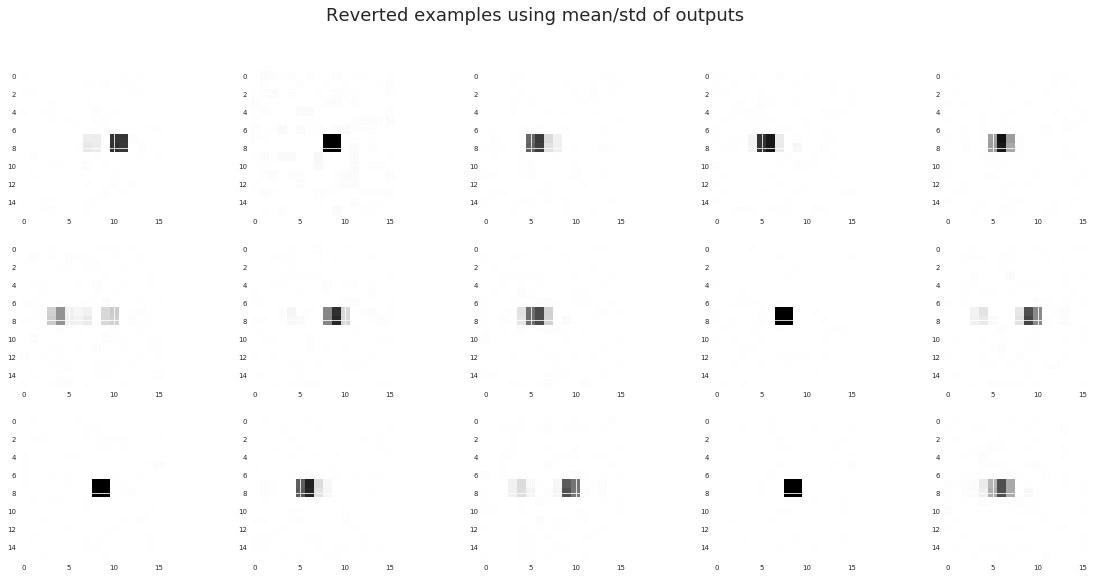

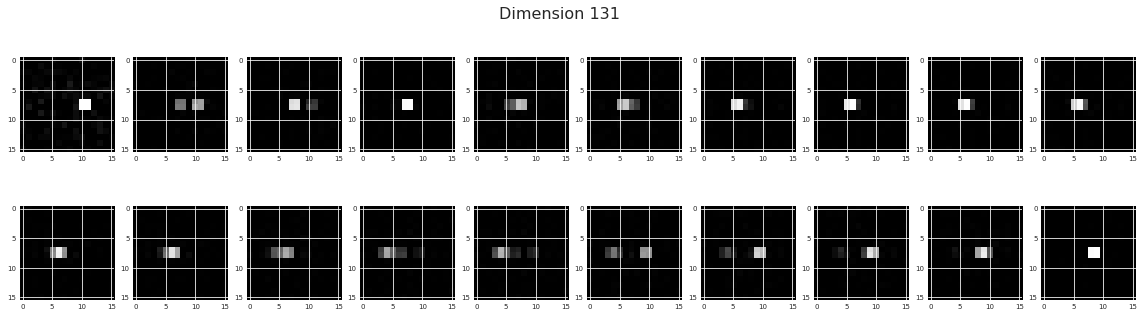

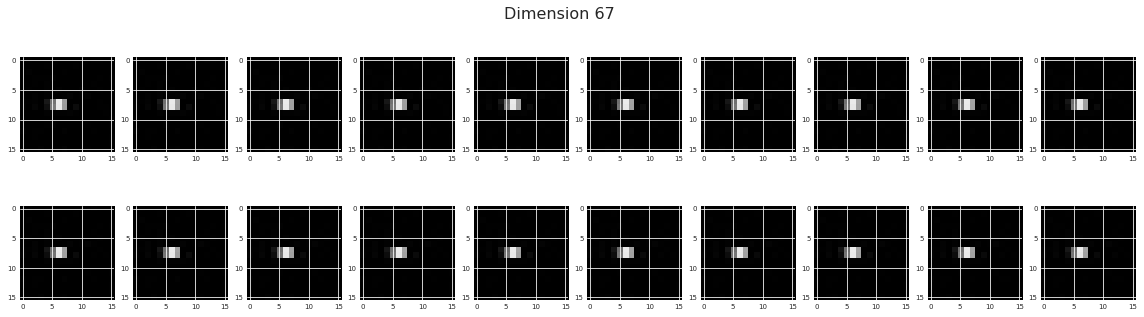

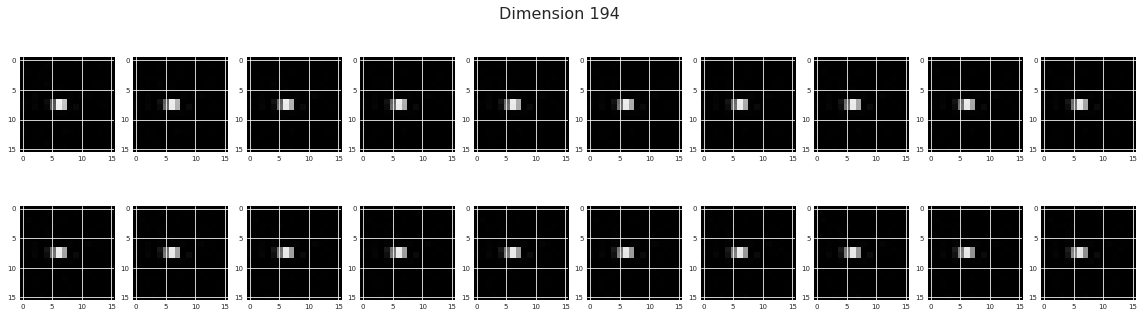

,total_loss
1110,0.654187


,total_loss
1120,0.651979


,total_loss
1130,0.668964


,total_loss
1140,0.692594


,total_loss
1150,0.65055


,total_loss
1160,0.681312


,total_loss
1170,0.648949


,total_loss
1180,0.674001


,total_loss
1190,0.625848


,total_loss
1200,0.687972


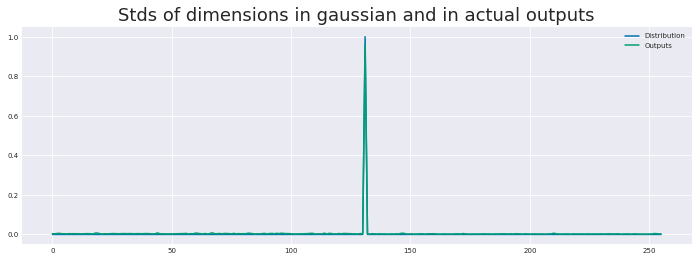

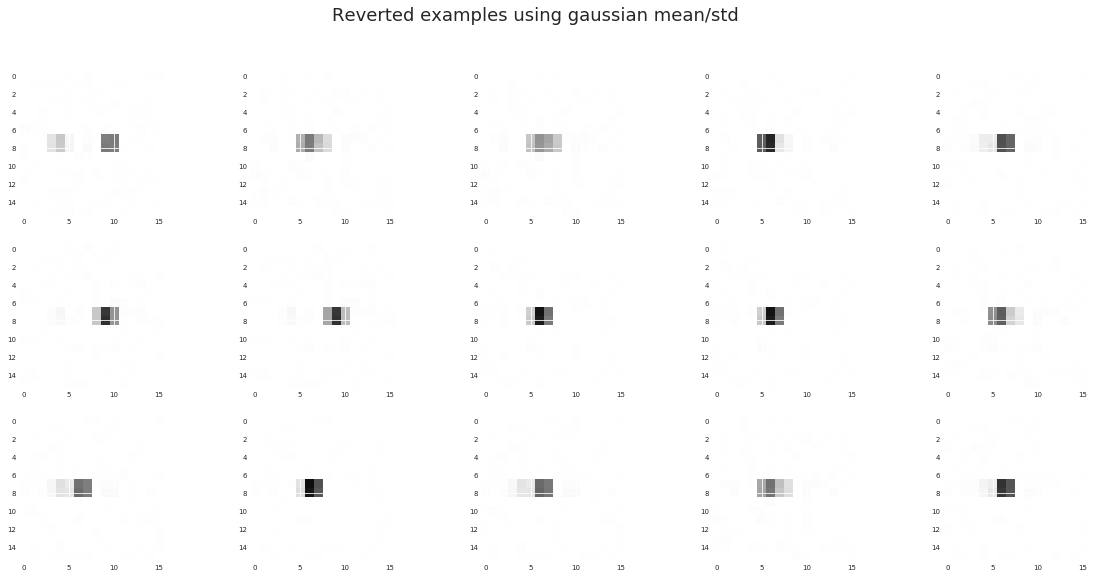

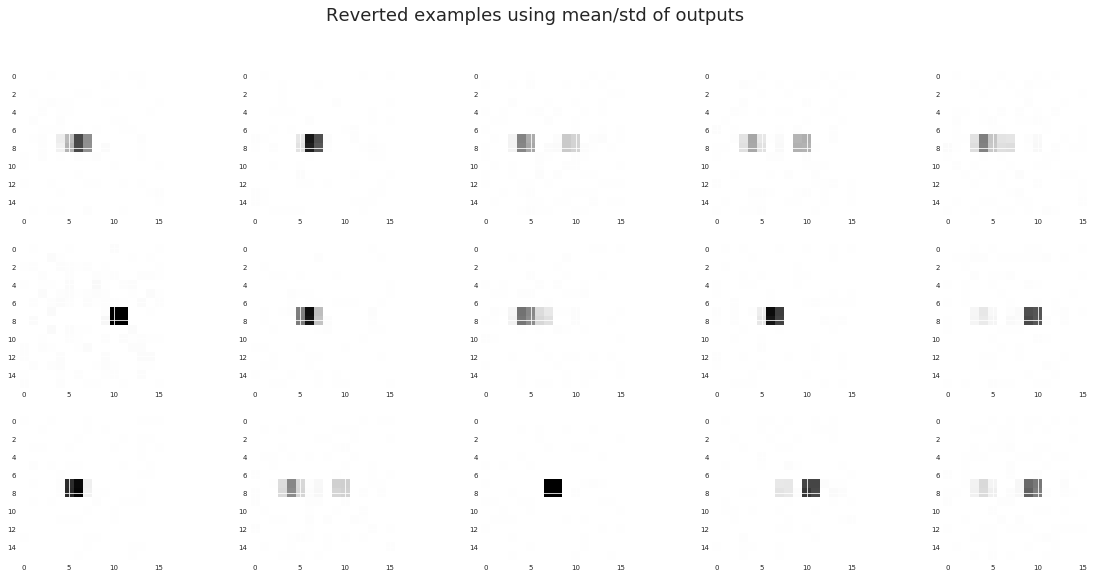

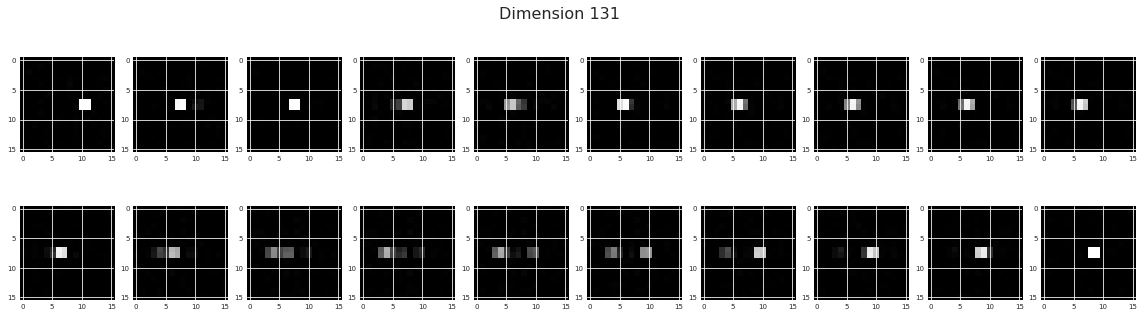

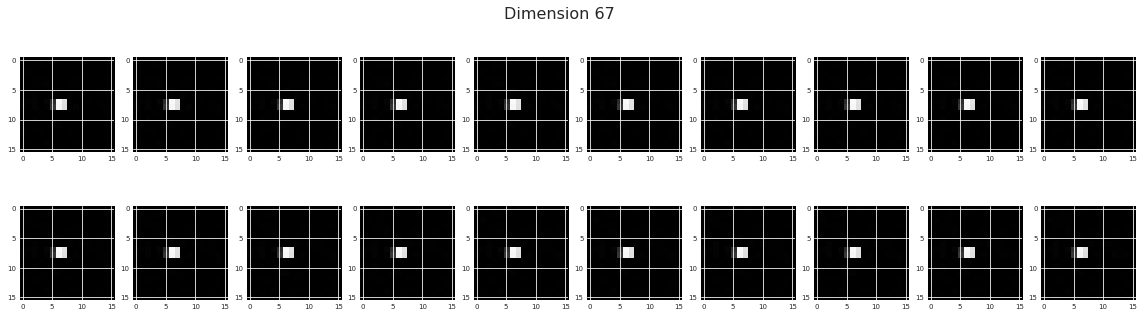

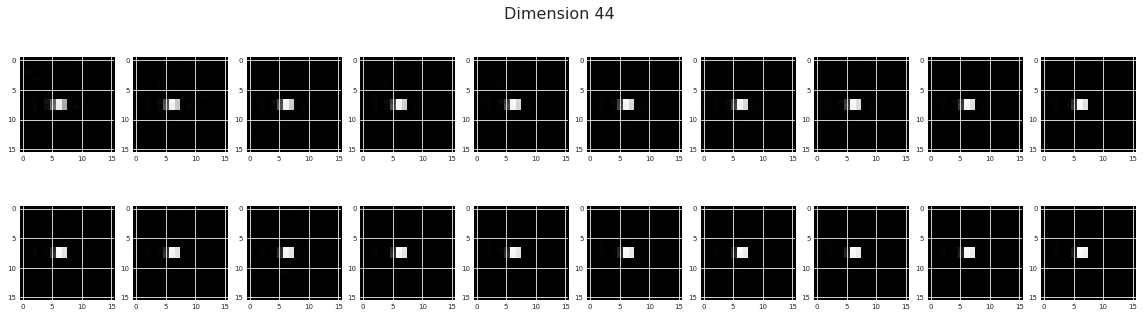

,total_loss
1210,0.670226


,total_loss
1220,0.656865


,total_loss
1230,0.700075


,total_loss
1240,0.612201


,total_loss
1250,0.614935


,total_loss
1260,0.661425


,total_loss
1270,0.666171


,total_loss
1280,0.65804


,total_loss
1290,0.677631


,total_loss
1300,0.666849


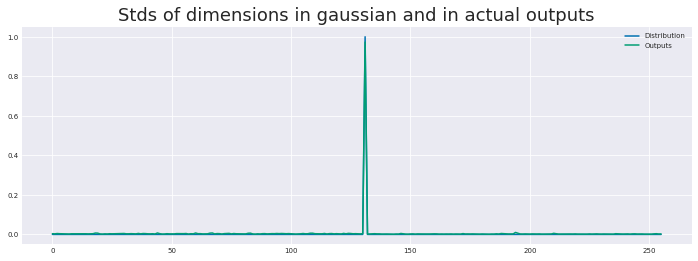

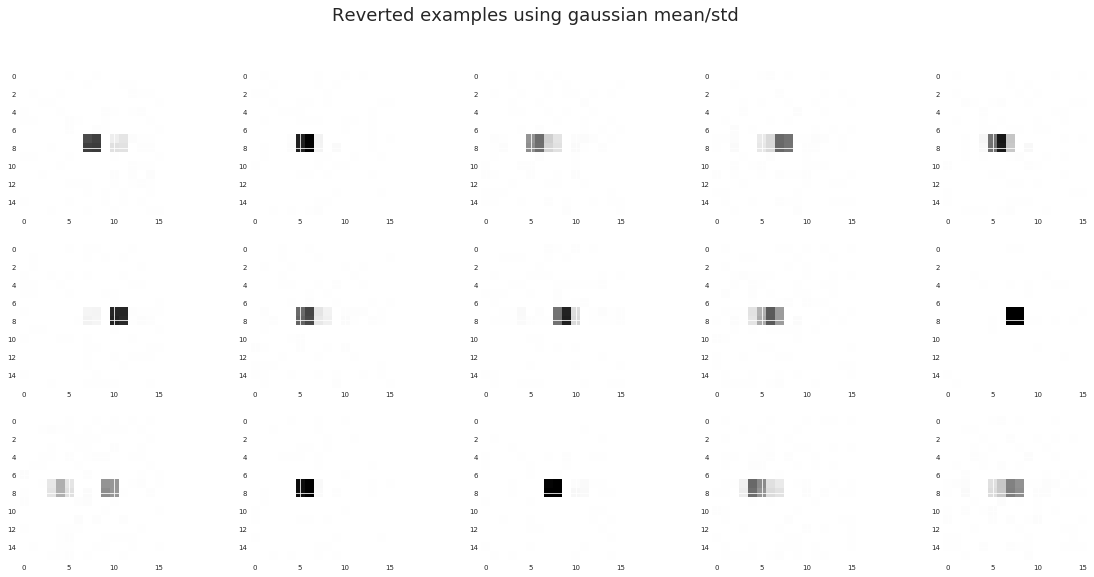

In [ ]:
import pandas as pd
from reversible.util import var_to_np, ensure_on_same_device
from reversible.revnet import get_inputs_from_reverted_samples


rng = RandomState(1)
epochs_dataframe = pd.DataFrame()
for i_epoch in range(100001):
    feature_model.train()
    used_stds = stds_per_dim
    for i_update in range(n_updates_per_epoch):
        if i_update % (n_critic_updates + 1) == n_critic_updates:
            # now run generator
            loss = train_one_batch(iterator, feature_model, loss_fn, means_per_dim, used_stds, optimizer)
            stds_per_dim.data.clamp_(min=0)
        else:
            loss = train_one_batch(iterator, feature_model, loss_fn_adv, means_per_dim, used_stds, optimizer_adv)
            stds_per_dim.data.clamp_(min=0) # should not be necessary...
    feature_model.eval()
    epochs_dataframe = epochs_dataframe.append({
        'total_loss': np.mean(loss),
    },
        ignore_index=True)
    if i_epoch % 10 == 0:
        display(epochs_dataframe.iloc[-1:])
    if i_epoch % 100 == 0:
        
        all_outs = feature_model(inputs)
        all_outs = var_to_np(all_outs).squeeze()
        
        for i_cluster in range(len(means_per_dim)):
            fig = plt.figure()
            plt.plot(var_to_np(used_stds[i_cluster]))
            plt.plot(np.std(all_outs[y == i_cluster], axis=0))
            plt.legend(('Distribution', 'Outputs'))
            plt.title("Stds of dimensions in gaussian and in actual outputs", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(len(means_per_dim)):
            rec_examples, _ = get_inputs_from_reverted_samples(
                 15, means_per_dim[i_cluster:i_cluster+1], used_stds[i_cluster:i_cluster+1],
                np_to_var([1,]), feature_model,
                to_4d=False)

            fig, axes = plt.subplots(3,5, figsize=(20,9))

            for i_example, ax in enumerate(axes.flatten()):
                ax.imshow(rec_examples[i_example].squeeze(), vmin=0, vmax=1, cmap=cm.Greys)
            fig.suptitle("Reverted examples using gaussian mean/std", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(len(means_per_dim)):
            mean =  np_to_var(np.mean(all_outs[y == i_cluster], axis=0, keepdims=True), dtype=np.float32)
            std = np_to_var(np.std(all_outs[y == i_cluster], axis=0, keepdims=True), dtype=np.float32)
            mean, std, inputs = ensure_on_same_device(mean,std,inputs)
            rec_examples, _ = get_inputs_from_reverted_samples(
                 15, mean, std,
                np_to_var([1,]), feature_model,
                to_4d=False)

            fig, axes = plt.subplots(3,5, figsize=(20,9))

            for i_example, ax in enumerate(axes.flatten()):
                ax.imshow(rec_examples[i_example].squeeze(), vmin=0, vmax=1, cmap=cm.Greys)
            fig.suptitle("Reverted examples using mean/std of outputs", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(len(means_per_dim)):
            stds = np.std(all_outs[y == i_cluster], axis=0)
            sorted_stds = np.argsort(stds)[::-1]
            for i_large_std in sorted_stds[:3]:
                stds_cloned = used_stds.clone()
                stds_cloned = stds_cloned * 0
                stds_cloned[i_cluster,i_large_std] = float(stds[i_large_std])
                rec_examples, gauss_samples = get_inputs_from_reverted_samples(
                    200, means_per_dim[i_cluster:i_cluster+1],
                    stds_cloned[i_cluster:i_cluster+1], np_to_var([1]), feature_model, to_4d=False)
                i_sort = np.argsort(var_to_np(gauss_samples)[:, i_large_std])
                sorted_examples = rec_examples[i_sort]
                sorted_examples = sorted_examples[::200//20]
                fig = plot_sorted_examples(sorted_examples)
                fig.suptitle("Dimension {:d}".format(i_large_std), fontsize=16)
                display(fig)
                plt.close(fig)

In [24]:
all_outs = feature_model(inputs)
all_outs = var_to_np(all_outs)

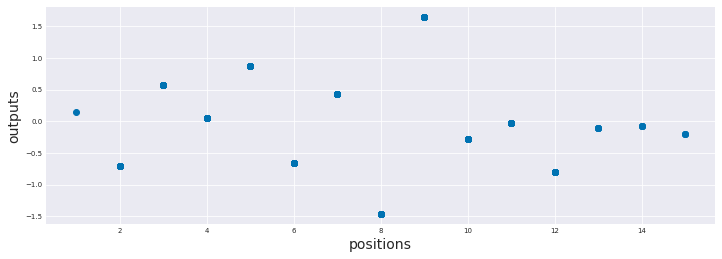

In [27]:
vals = all_outs[:,131]
plt.plot(positions, vals, ls='', marker='o')
plt.xlabel('positions', fontsize=14)
plt.ylabel('outputs', fontsize=14)

In [36]:
wanted = [np.flatnonzero(x[:,0,8,i_pos])[0] for i_pos in np.unique(positions)]

In [42]:
this_in = inputs.index_select(dim=0, index=np_to_var(wanted, dtype=np.int64).cuda())

In [45]:
this_outs = var_to_np(feature_model(this_in))

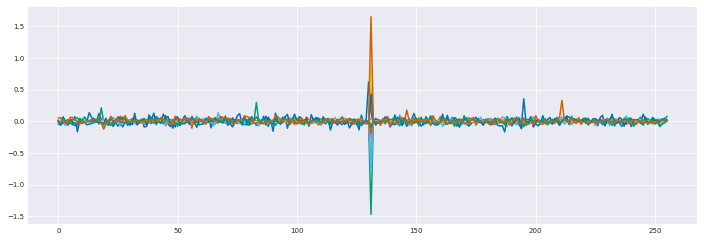

In [48]:
plt.plot(this_outs.T);

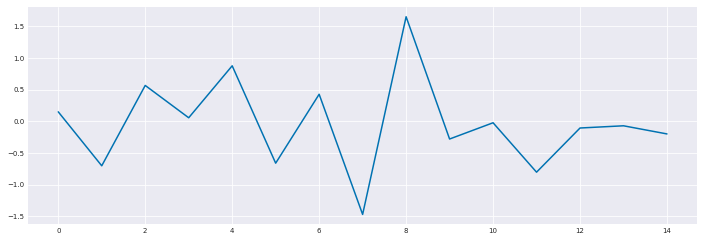

In [49]:
plt.plot(this_outs[:,131])

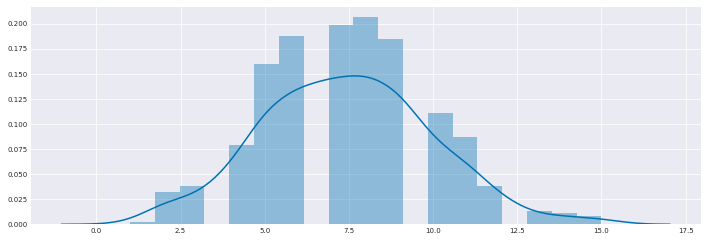

In [31]:
seaborn.distplot(positions)

In [29]:
all_outs[:,131]

array([-1.47033215,  1.64844644,  0.42541194,  0.42541194,  0.42541194,
       -0.66206443, -0.66206443, -0.28067812,  1.64844644,  0.42541194,
       -1.47033215,  0.42541194, -0.66206443, -1.47033215,  1.64844644,
       -0.66206443,  1.64844644, -0.28067812, -0.70315814,  0.87444562,
        0.87444562,  1.64844644,  1.64844644,  0.87444562,  0.05459582,
        1.64844644, -1.47033215, -1.47033215,  0.87444562,  1.64844644,
       -1.47033215, -0.28067812, -0.80390859,  0.42541194,  0.42541194,
       -1.47033215,  0.42541194,  0.42541194, -0.66206443, -0.02432314,
        1.64844644,  0.87444562,  0.42541194, -0.28067812,  0.42541194,
       -0.20052752,  0.87444562,  0.42541194,  0.42541194,  0.87444562,
        1.64844644, -0.66206443, -1.47033215, -0.28067812,  0.05459582,
        1.64844644, -1.47033215, -1.47033215, -1.47033215,  1.64844644,
        0.87444562, -0.28067812, -1.47033215,  1.64844644, -0.28067812,
        1.64844644,  0.87444562, -1.47033215, -0.66206443, -1.47